In [1]:
%matplotlib inline

import numpy as np
import copy
import matplotlib.pyplot as plt
import pickle
import random
import torch
from utils import torch_from_numpy
import datetime

from config import cfg_seed, cfg_env, cfg_z_dim, cfg_default_lr, cfg_default_early, cfg_policy_evaluation_maxiter
seed = cfg_seed
env_str=cfg_env
default_lr=cfg_default_lr
default_early=cfg_default_early

from config import cfg_alpha
alpha=cfg_alpha

num_iter_max=200000
env_name = 'CustomCartPole-v0'
env_str=cfg_env
figfilenamehead = "fig_policy_optimization_"+env_str+"_iter1_"

loss_list = []
normalized_loss_list = []

policy_evaluation_maxiter = cfg_policy_evaluation_maxiter
print("policy_evaluation_maxiter",policy_evaluation_maxiter)
print("alpha",alpha)
print("seed",seed)
print(datetime.datetime.now())

policy_evaluation_maxiter 5
alpha 0.2
seed 1
2023-07-24 06:15:54.060877


In [2]:
import gym
import custom_gym
env = gym.make(env_name)

np.random.seed(seed)
random.seed(seed)
env.seed(seed)
env.action_space.seed(seed)
torch.manual_seed(seed)

s_dim = env.reset().flatten().shape[0]
a_dim = env.action_space.sample().flatten().shape[0]
z_dim = cfg_z_dim
print(s_dim, a_dim, z_dim)



4 1 2


/home/proxima-hishinuma/anaconda3/envs/iwvi/lib/python3.8/site-packages/gym/core.py:329: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/home/proxima-hishinuma/anaconda3/envs/iwvi/lib/python3.8/site-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/home/proxima-hishinuma/anaconda3/envs/iwvi/lib/python3.8/site-packages/gym/core.py:268: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(


In [3]:


from sac import SAC
# agent = SAC(env.observation_space.shape[0], env.action_space)
agent = SAC(env.observation_space.shape[0]+z_dim*2, env.action_space)
agent.load_checkpoint(ckpt_path="checkpoints/sac_checkpoint_custom_"+env_str+"_bamdp_standardvae_")


offline_data = pickle.load(open("offline_data_"+env_str+".pkl","rb"))
debug_info = pickle.load(open("offline_data_debug_info_"+env_str+".pkl","rb"))
debug_info = np.array(debug_info)

Loading models from checkpoints/sac_checkpoint_custom_cartpole_bamdp_standardvae_


In [4]:
args_init_dict = {
    "offline_data": offline_data,
    "s_dim": s_dim,
    "a_dim": a_dim,
    "z_dim": z_dim,
    #              "policy":agent.select_action,
    "mdp_policy":None,
    "bamdp_policy":agent.policy.my_np_select_action,
    "debug_info":debug_info,
    "env" : env,
    "ckpt_suffix" : env_str,
}
# import vi_base
# vi = vi_base.baseVI(args_init_dict)
import vi_iw
iwvi = vi_iw.iwVI(args_init_dict)

iwvi.load_base(ckpt_key="unweighted")
# iwvi.update_mulogvar_offlinedata()

dec: h_dim 64
base load ckpt ckpt_basevi_cartpole_unweighted
base load self.initial_belief.data.sum() tensor(-6.2511)
base load dec.state_dict()['net_phat.0.weight'].sum() tensor(-5.0844)
penalty_target_min tensor(-12.3053) penalty_target_max tensor(-2.7621)
train_loss:  -10.527545507049561
valid_loss:  -10.271352688598634
h_min_tilde -12.3053055 ell_tilde -10.476306943359376 kappa_tilde 0.0007394236224012372


In [5]:
iwvi.get_real_rollout_bamdppolicy_data()


 0 1.9073486328125e-06


/home/proxima-hishinuma/anaconda3/envs/iwvi/lib/python3.8/site-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):



 1 3.85073184967041

 2 3.354158401489258

 3 5.9320714473724365

 4 3.497645378112793

 5 3.230670928955078

 6 3.3823201656341553

 7 3.2528748512268066

 8 3.3502979278564453

 9 3.2134296894073486

 10 3.369542360305786

 11 3.120774745941162

 12 3.5113394260406494

 13 3.5487916469573975

 14 3.4698126316070557

 15 3.319282054901123

 16 3.4248483180999756

 17 3.442429304122925

 18 3.949080228805542

 19 3.3695454597473145

 20 3.334244728088379

 21 3.1186764240264893

 22 3.63079833984375

 23 3.488454580307007

 24 3.6500678062438965

 25 5.285015106201172

 26 7.341759443283081

 27 7.015350341796875

 28 7.132126331329346

 29 6.964034557342529

 30 7.062114238739014

 31 7.158976793289185

 32 7.0573647022247314

 33 5.774047136306763

 34 3.2656776905059814

 35 3.384364128112793

 36 3.449289083480835

 37 3.1230764389038086

 38 3.580033302307129

 39 3.633746385574341

 40 3.3718507289886475

 41 3.345311403274536

 42 3.2289135456085205

 43 3.285566806793213

 44 

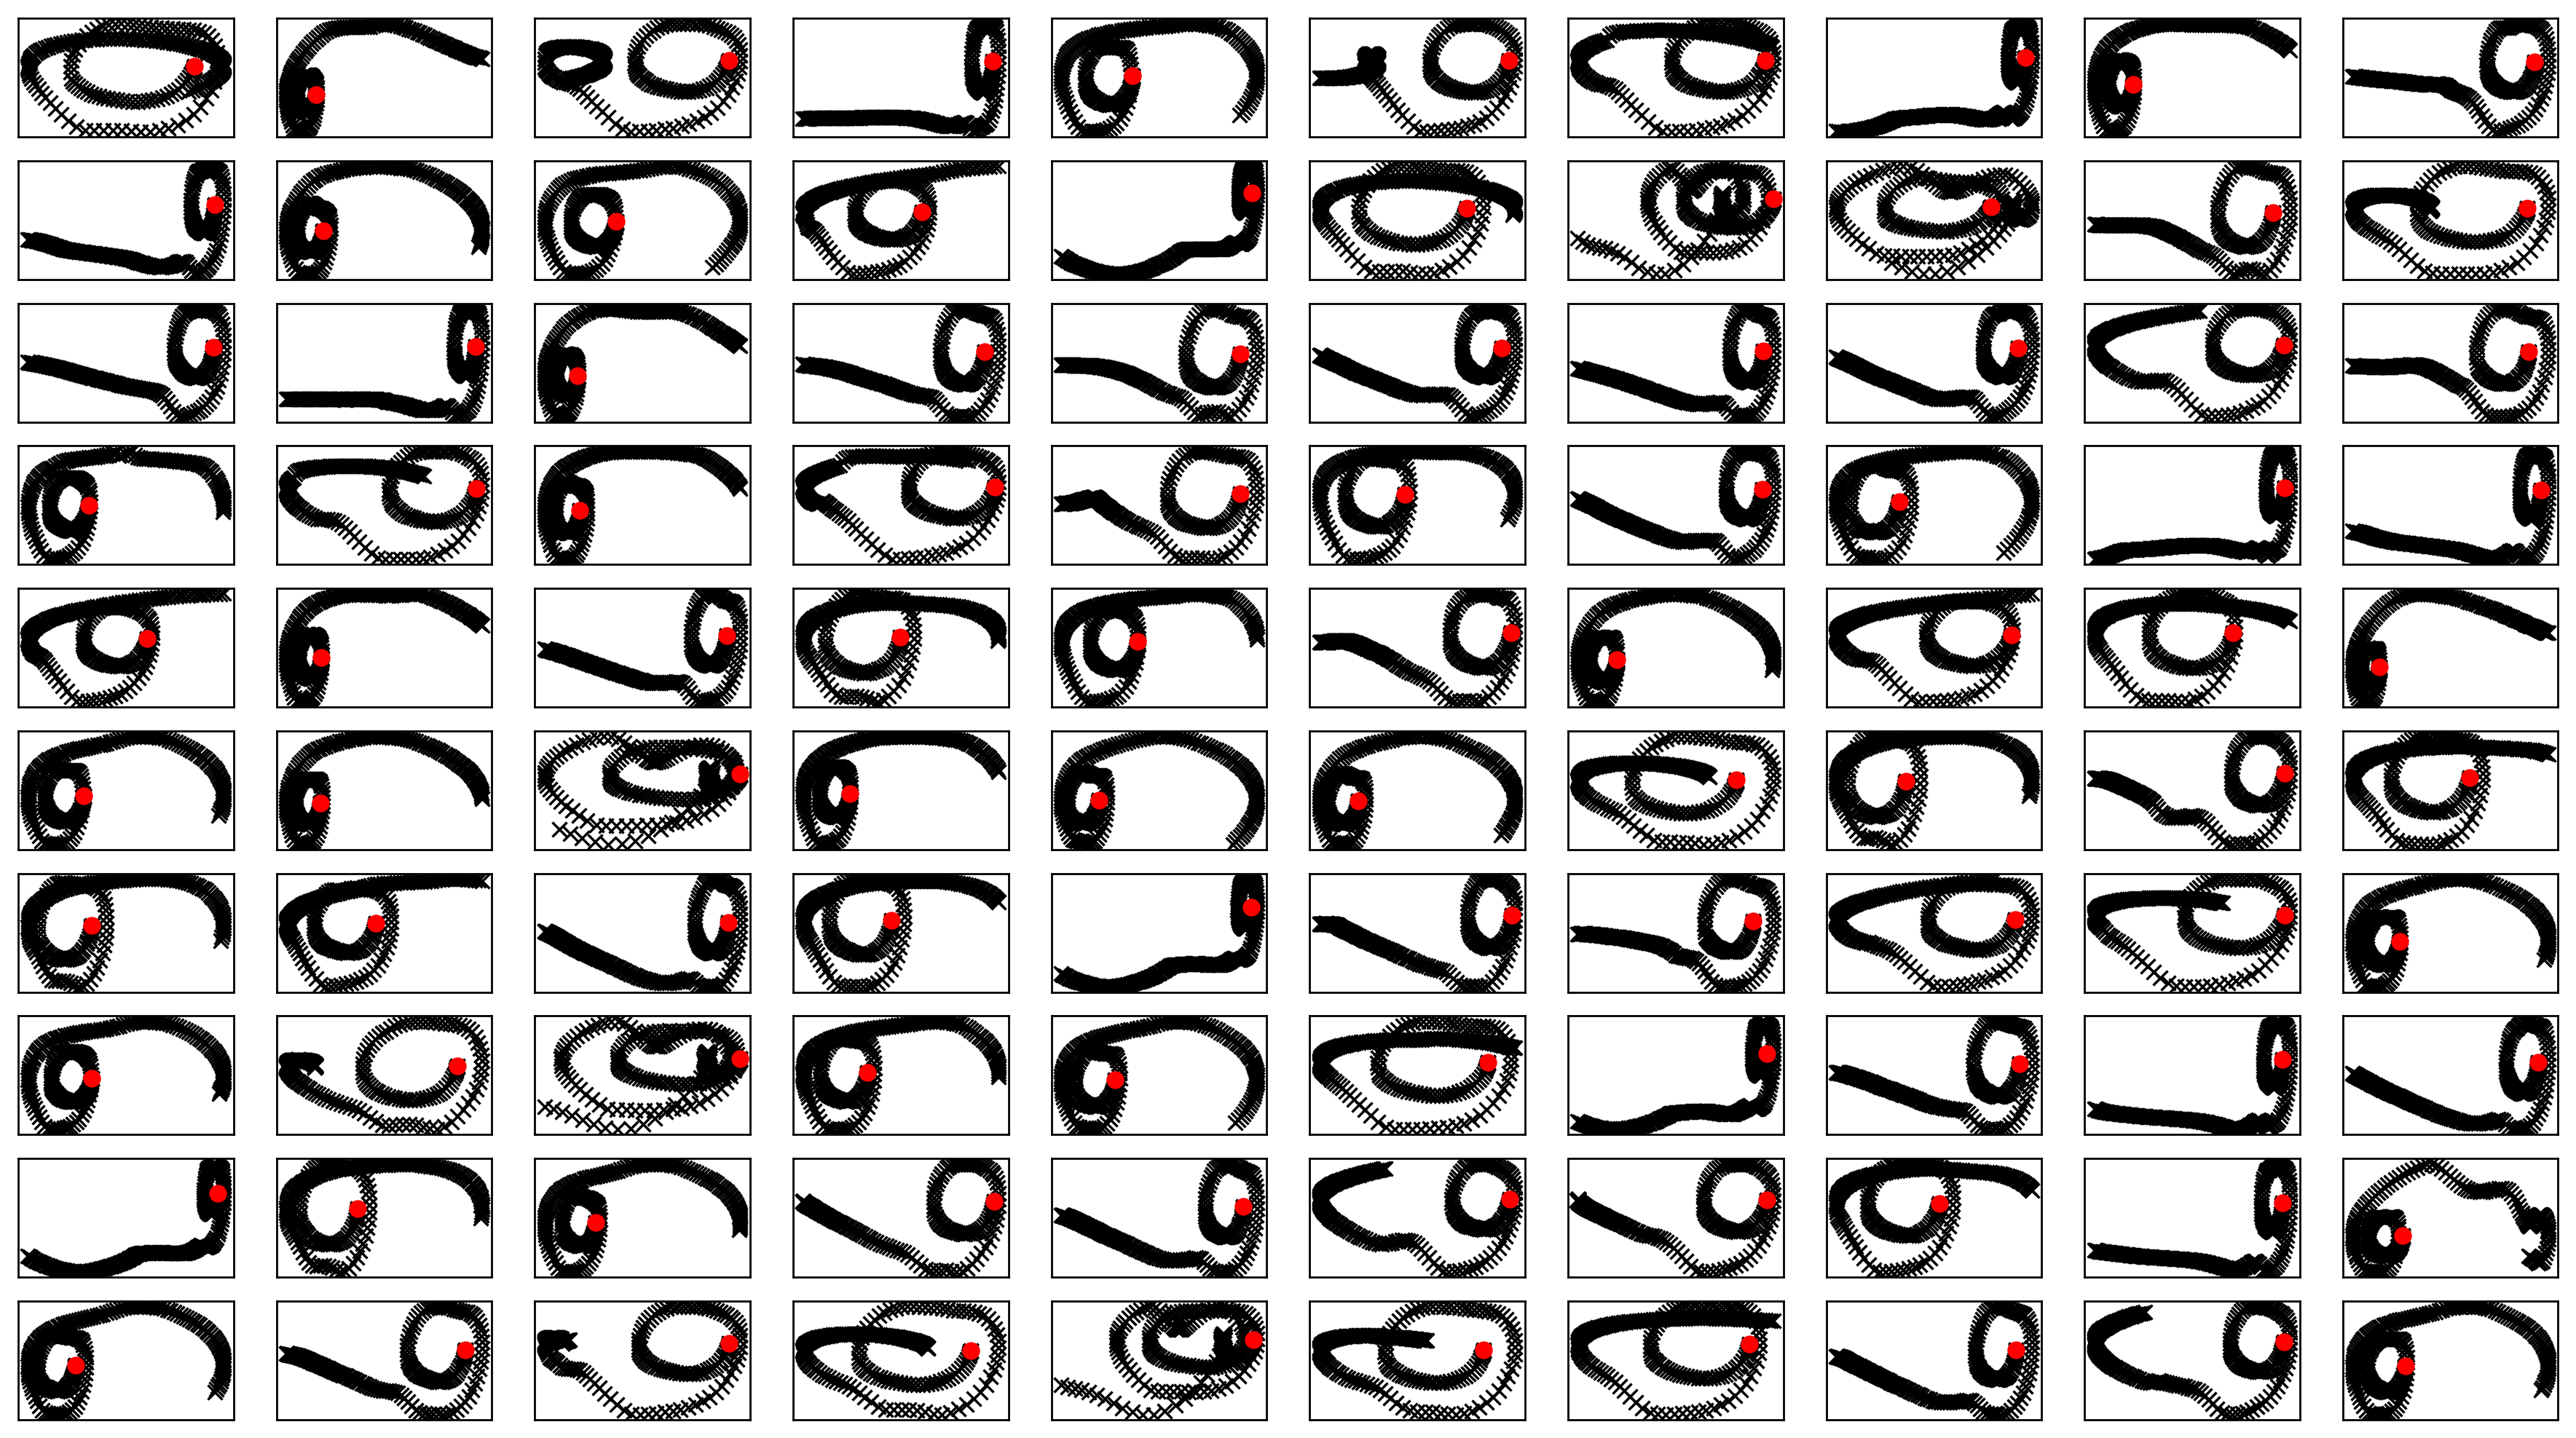

In [6]:
fig = plt.figure(figsize=(18,10), dpi=250)
fig.patch.set_facecolor('white')
ax_list = []
for i in range(len(offline_data)):
    ax_list.append(fig.add_subplot(len(offline_data)//10, 10, i+1))
    ax_list[-1].set_xticks([])
    ax_list[-1].set_yticks([])
    ax_list[-1].plot(iwvi.debug_realenv_rolloutdata[i][:,0], iwvi.debug_realenv_rolloutdata[i][:,1],"kx")
    ax_list[-1].plot(0, 0,"ro") 
plt.show()

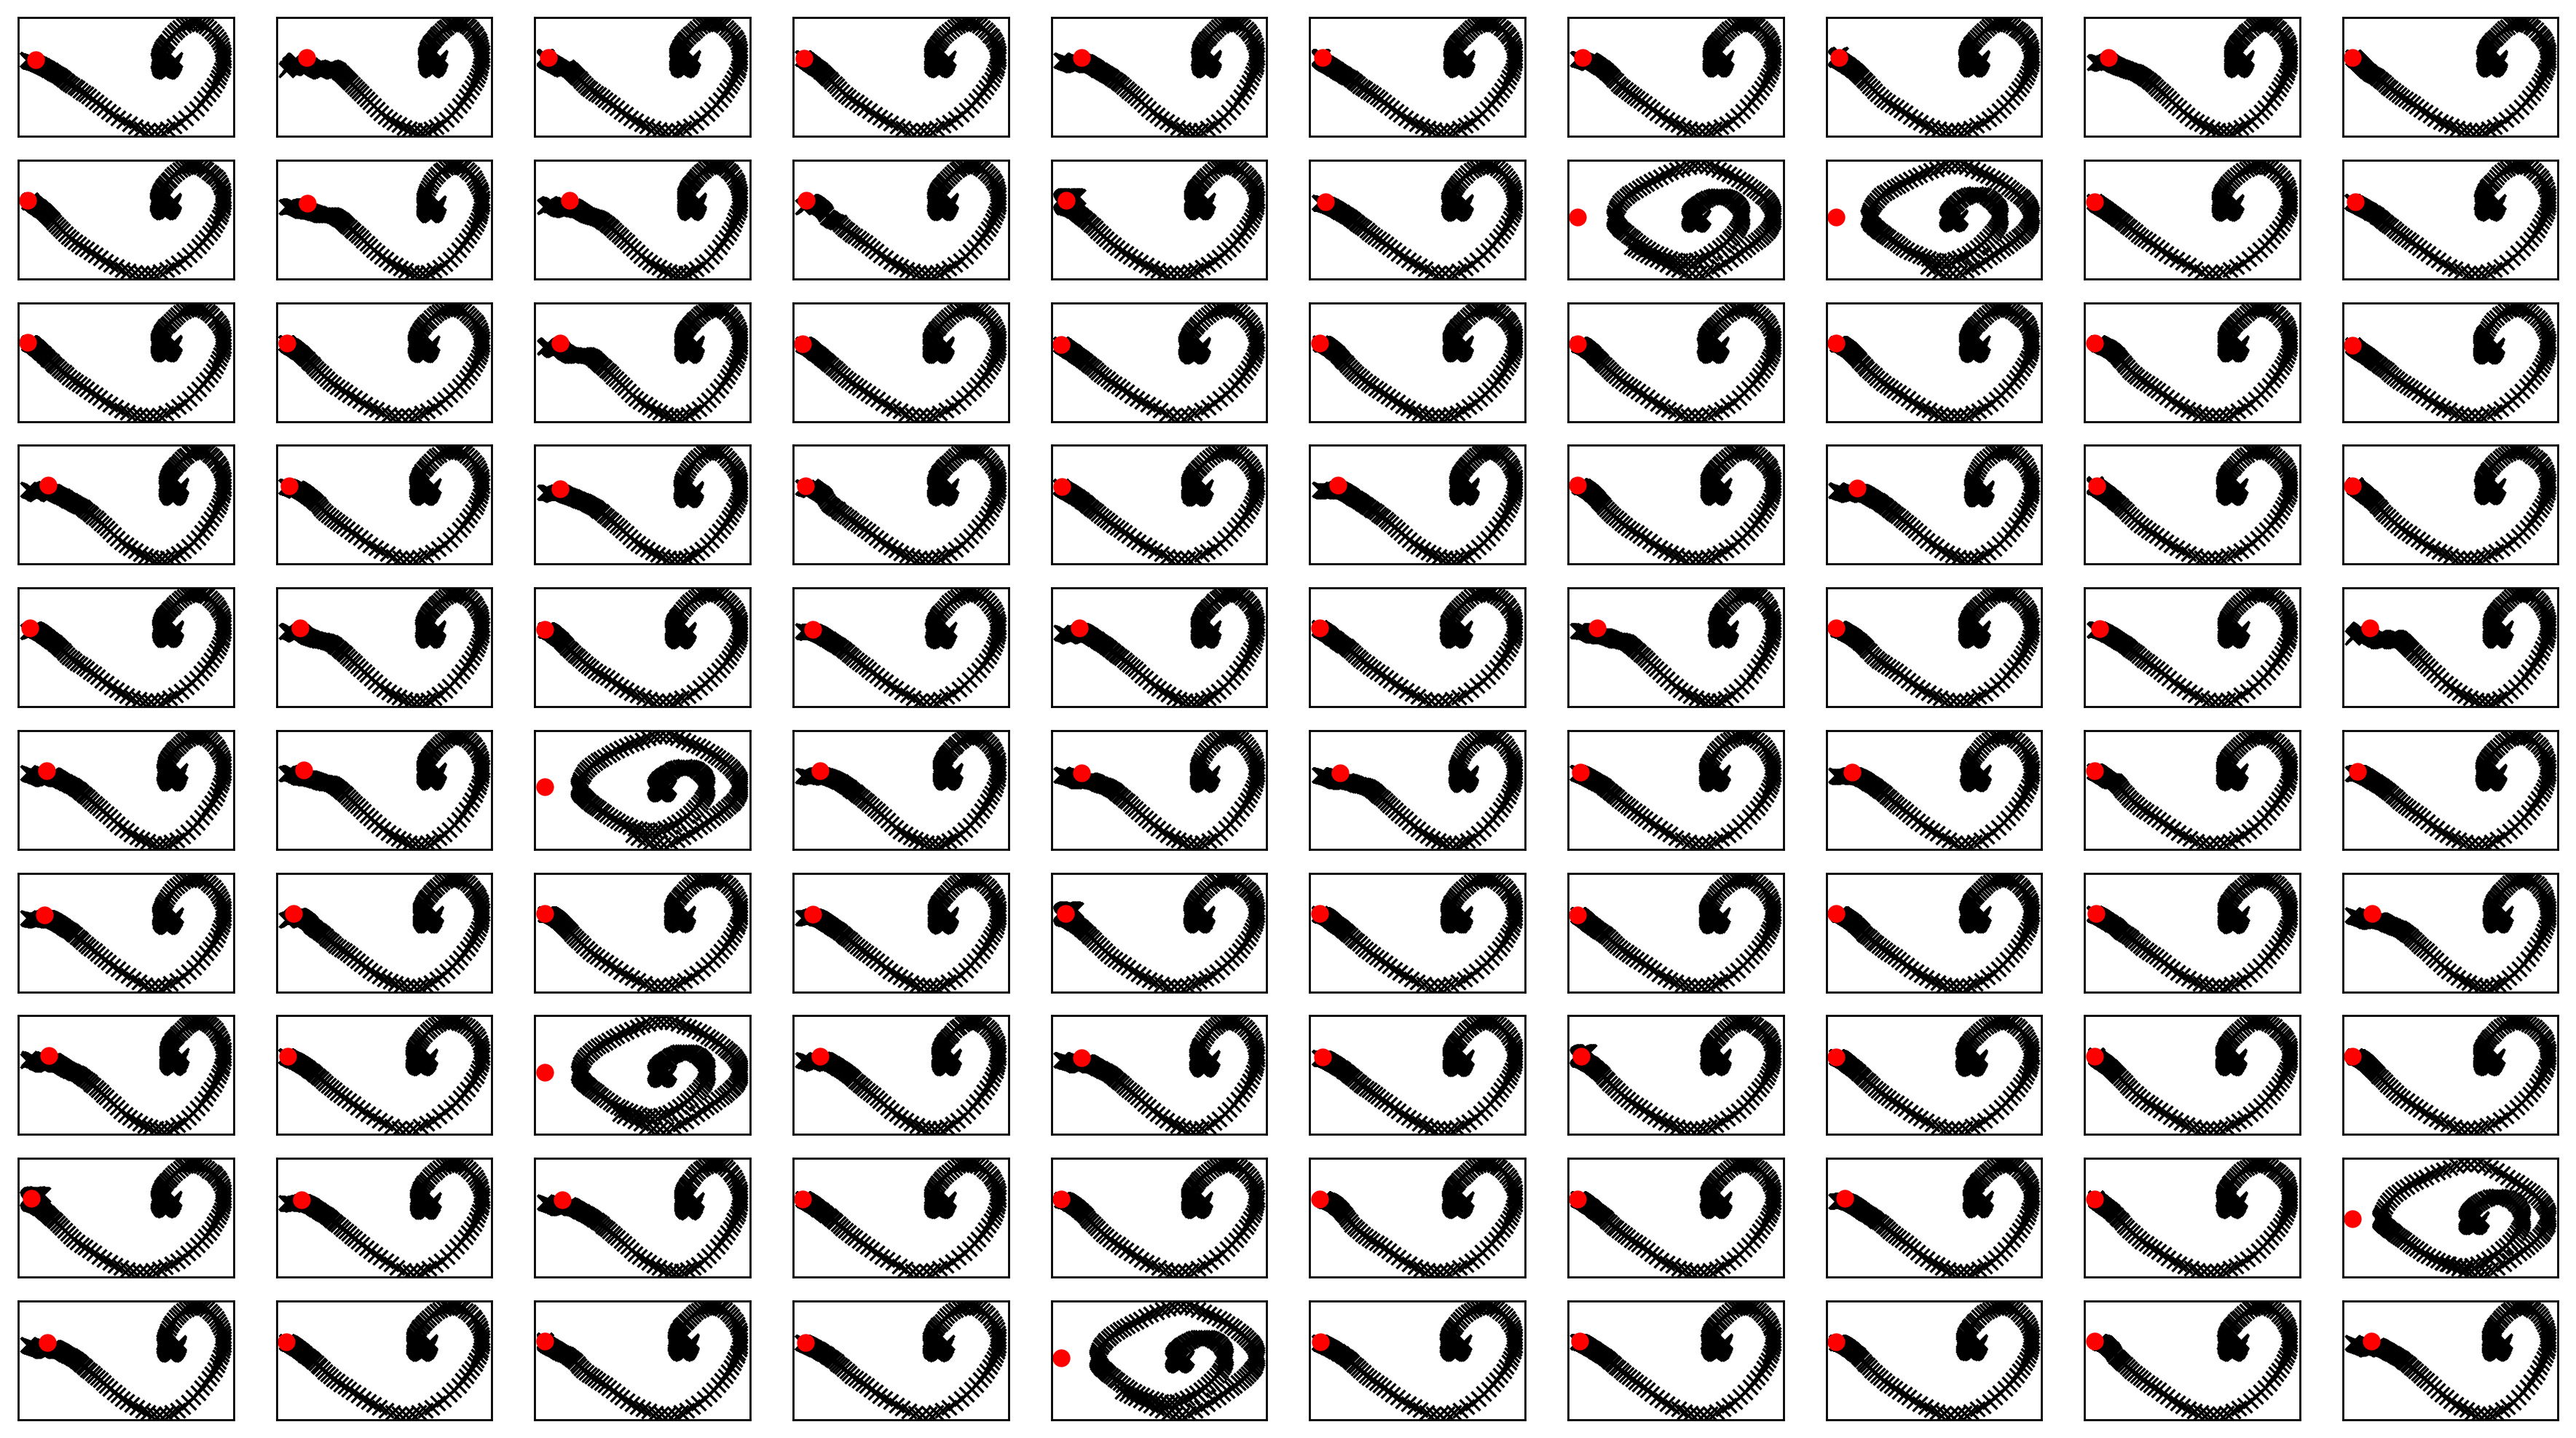

In [7]:
fig = plt.figure(figsize=(18,10), dpi=250)
fig.patch.set_facecolor('white')
ax_list = []
for i in range(len(offline_data)):
    ax_list.append(fig.add_subplot(len(offline_data)//10, 10, i+1))
    ax_list[-1].set_xticks([])
    ax_list[-1].set_yticks([])
    ax_list[-1].plot(iwvi.debug_realenv_rolloutdata[i][:,2], iwvi.debug_realenv_rolloutdata[i][:,3],"kx")
    ax_list[-1].plot(0, 0,"ro") 
plt.show()

In [8]:
print(datetime.datetime.now())

2023-07-24 06:22:29.027586


# Iter 1

In [9]:
policy_evaluation_iter=0

In [10]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    iwvi.get_sim_rollout_bamdppolicy_data_randomstop()


 0

 1

 2

 3

 4

 5

 6

 7

 8

 9

 10

 11

 12

 13

 14

 15

 16

 17

 18

 19

 20

 21

 22

 23

 24

 25

 26

 27

 28

 29

 30

 31

 32

 33

 34

 35

 36

 37

 38

 39

 40

 41

 42

 43

 44

 45

 46

 47

 48

 49

 50

 51

 52

 53

 54

 55

 56

 57

 58

 59

 60

 61

 62

 63

 64

 65

 66

 67

 68

 69

 70

 71

 72

 73

 74

 75

 76

 77

 78

 79

 80

 81

 82

 83

 84

 85

 86

 87

 88

 89

 90

 91

 92

 93

 94

 95

 96

 97

 98

 99
 


In [11]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    iwvi.train_ratio(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, policy=agent.select_action)


train: iter 0  trainloss 1.36209  validloss 1.41525±0.00000  bestvalidloss 1.41525  last_update 0
train: iter 1  trainloss 1.28209  validloss 1.33402±0.00000  bestvalidloss 1.33402  last_update 0
train: iter 2  trainloss 1.24700  validloss 1.30281±0.00000  bestvalidloss 1.30281  last_update 0
train: iter 3  trainloss 1.23422  validloss 1.28913±0.00000  bestvalidloss 1.28913  last_update 0
train: iter 4  trainloss 1.22659  validloss 1.27392±0.00000  bestvalidloss 1.27392  last_update 0
train: iter 5  trainloss 1.21289  validloss 1.26063±0.00000  bestvalidloss 1.26063  last_update 0
train: iter 6  trainloss 1.20419  validloss 1.25760±0.00000  bestvalidloss 1.25760  last_update 0
train: iter 7  trainloss 1.19025  validloss 1.23784±0.00000  bestvalidloss 1.23784  last_update 0
train: iter 8  trainloss 1.17467  validloss 1.21811±0.00000  bestvalidloss 1.21811  last_update 0
train: iter 9  trainloss 1.15145  validloss 1.20110±0.00000  bestvalidloss 1.20110  last_update 0
train: iter 10  trai

train: iter 83  trainloss 0.85326  validloss 0.95952±0.00000  bestvalidloss 0.92606  last_update 1
train: iter 84  trainloss 0.84719  validloss 0.94531±0.00000  bestvalidloss 0.92606  last_update 2
train: iter 85  trainloss 0.84744  validloss 0.92402±0.00000  bestvalidloss 0.92402  last_update 0
train: iter 86  trainloss 0.85189  validloss 0.93193±0.00000  bestvalidloss 0.92402  last_update 1
train: iter 87  trainloss 0.84838  validloss 0.92686±0.00000  bestvalidloss 0.92402  last_update 2
train: iter 88  trainloss 0.85518  validloss 0.92067±0.00000  bestvalidloss 0.92067  last_update 0
train: iter 89  trainloss 0.84727  validloss 0.93445±0.00000  bestvalidloss 0.92067  last_update 1
train: iter 90  trainloss 0.84462  validloss 0.91829±0.00000  bestvalidloss 0.91829  last_update 0
train: iter 91  trainloss 0.84947  validloss 0.92084±0.00000  bestvalidloss 0.91829  last_update 1
train: iter 92  trainloss 0.83778  validloss 0.93841±0.00000  bestvalidloss 0.91829  last_update 2
train: ite

train: iter 166  trainloss 0.76898  validloss 0.80248±0.00000  bestvalidloss 0.80248  last_update 0
train: iter 167  trainloss 0.77648  validloss 0.84327±0.00000  bestvalidloss 0.80248  last_update 1
train: iter 168  trainloss 0.77293  validloss 0.82259±0.00000  bestvalidloss 0.80248  last_update 2
train: iter 169  trainloss 0.77343  validloss 0.82110±0.00000  bestvalidloss 0.80248  last_update 3
train: iter 170  trainloss 0.76603  validloss 0.80569±0.00000  bestvalidloss 0.80248  last_update 4
train: iter 171  trainloss 0.76812  validloss 0.80841±0.00000  bestvalidloss 0.80248  last_update 5
train: iter 172  trainloss 0.76864  validloss 0.81468±0.00000  bestvalidloss 0.80248  last_update 6
train: iter 173  trainloss 0.76354  validloss 0.80415±0.00000  bestvalidloss 0.80248  last_update 7
train: iter 174  trainloss 0.77015  validloss 0.81992±0.00000  bestvalidloss 0.80248  last_update 8
train: iter 175  trainloss 0.76982  validloss 0.80975±0.00000  bestvalidloss 0.80248  last_update 9


train: iter 248  trainloss 0.72691  validloss 0.78328±0.00000  bestvalidloss 0.76893  last_update 7
train: iter 249  trainloss 0.72103  validloss 0.78187±0.00000  bestvalidloss 0.76893  last_update 8
train: iter 250  trainloss 0.72257  validloss 0.77374±0.00000  bestvalidloss 0.76893  last_update 9
train: iter 251  trainloss 0.71961  validloss 0.77858±0.00000  bestvalidloss 0.76893  last_update 10
train: iter 252  trainloss 0.72232  validloss 0.76209±0.00000  bestvalidloss 0.76209  last_update 0
train: iter 253  trainloss 0.71342  validloss 0.76491±0.00000  bestvalidloss 0.76209  last_update 1
train: iter 254  trainloss 0.71492  validloss 0.76933±0.00000  bestvalidloss 0.76209  last_update 2
train: iter 255  trainloss 0.72508  validloss 0.79792±0.00000  bestvalidloss 0.76209  last_update 3
train: iter 256  trainloss 0.71433  validloss 0.78378±0.00000  bestvalidloss 0.76209  last_update 4
train: iter 257  trainloss 0.71816  validloss 0.76826±0.00000  bestvalidloss 0.76209  last_update 5

train: iter 331  trainloss 0.68417  validloss 0.74100±0.00000  bestvalidloss 0.74100  last_update 0
train: iter 332  trainloss 0.68374  validloss 0.75943±0.00000  bestvalidloss 0.74100  last_update 1
train: iter 333  trainloss 0.67679  validloss 0.74626±0.00000  bestvalidloss 0.74100  last_update 2
train: iter 334  trainloss 0.68352  validloss 0.77153±0.00000  bestvalidloss 0.74100  last_update 3
train: iter 335  trainloss 0.69796  validloss 0.77306±0.00000  bestvalidloss 0.74100  last_update 4
train: iter 336  trainloss 0.68538  validloss 0.75400±0.00000  bestvalidloss 0.74100  last_update 5
train: iter 337  trainloss 0.68550  validloss 0.75274±0.00000  bestvalidloss 0.74100  last_update 6
train: iter 338  trainloss 0.68713  validloss 0.75204±0.00000  bestvalidloss 0.74100  last_update 7
train: iter 339  trainloss 0.67713  validloss 0.75761±0.00000  bestvalidloss 0.74100  last_update 8
train: iter 340  trainloss 0.67483  validloss 0.75789±0.00000  bestvalidloss 0.74100  last_update 9


train: iter 413  trainloss 0.65472  validloss 0.76928±0.00000  bestvalidloss 0.74100  last_update 82
train: iter 414  trainloss 0.65875  validloss 0.76497±0.00000  bestvalidloss 0.74100  last_update 83
train: iter 415  trainloss 0.65241  validloss 0.75056±0.00000  bestvalidloss 0.74100  last_update 84
train: iter 416  trainloss 0.65857  validloss 0.76450±0.00000  bestvalidloss 0.74100  last_update 85
train: iter 417  trainloss 0.66445  validloss 0.75351±0.00000  bestvalidloss 0.74100  last_update 86
train: iter 418  trainloss 0.65533  validloss 0.74876±0.00000  bestvalidloss 0.74100  last_update 87
train: iter 419  trainloss 0.65176  validloss 0.75750±0.00000  bestvalidloss 0.74100  last_update 88
train: iter 420  trainloss 0.65306  validloss 0.76292±0.00000  bestvalidloss 0.74100  last_update 89
train: iter 421  trainloss 0.65567  validloss 0.75120±0.00000  bestvalidloss 0.74100  last_update 90
train: iter 422  trainloss 0.65291  validloss 0.75953±0.00000  bestvalidloss 0.74100  last_

train: iter 495  trainloss 0.63058  validloss 0.83548±0.00000  bestvalidloss 0.72455  last_update 17
train: iter 496  trainloss 0.63162  validloss 0.73355±0.00000  bestvalidloss 0.72455  last_update 18
train: iter 497  trainloss 0.63307  validloss 0.73540±0.00000  bestvalidloss 0.72455  last_update 19
train: iter 498  trainloss 0.62509  validloss 0.74389±0.00000  bestvalidloss 0.72455  last_update 20
train: iter 499  trainloss 0.63255  validloss 0.72795±0.00000  bestvalidloss 0.72455  last_update 21
train: iter 500  trainloss 0.63554  validloss 0.75155±0.00000  bestvalidloss 0.72455  last_update 22
train: iter 501  trainloss 0.62243  validloss 0.74911±0.00000  bestvalidloss 0.72455  last_update 23
train: iter 502  trainloss 0.63840  validloss 0.74078±0.00000  bestvalidloss 0.72455  last_update 24
train: iter 503  trainloss 0.62954  validloss 0.78584±0.00000  bestvalidloss 0.72455  last_update 25
train: iter 504  trainloss 0.62914  validloss 0.73245±0.00000  bestvalidloss 0.72455  last_

train: iter 577  trainloss 0.61607  validloss 0.72631±0.00000  bestvalidloss 0.70865  last_update 1
train: iter 578  trainloss 0.60523  validloss 0.71893±0.00000  bestvalidloss 0.70865  last_update 2
train: iter 579  trainloss 0.61423  validloss 0.72872±0.00000  bestvalidloss 0.70865  last_update 3
train: iter 580  trainloss 0.60640  validloss 0.72982±0.00000  bestvalidloss 0.70865  last_update 4
train: iter 581  trainloss 0.61379  validloss 0.72171±0.00000  bestvalidloss 0.70865  last_update 5
train: iter 582  trainloss 0.61193  validloss 0.72587±0.00000  bestvalidloss 0.70865  last_update 6
train: iter 583  trainloss 0.60998  validloss 0.71851±0.00000  bestvalidloss 0.70865  last_update 7
train: iter 584  trainloss 0.60486  validloss 0.73635±0.00000  bestvalidloss 0.70865  last_update 8
train: iter 585  trainloss 0.60428  validloss 0.72426±0.00000  bestvalidloss 0.70865  last_update 9
train: iter 586  trainloss 0.60666  validloss 0.76545±0.00000  bestvalidloss 0.70865  last_update 10

train: iter 659  trainloss 0.58195  validloss 0.70718±0.00000  bestvalidloss 0.69985  last_update 1
train: iter 660  trainloss 0.58257  validloss 0.72608±0.00000  bestvalidloss 0.69985  last_update 2
train: iter 661  trainloss 0.58576  validloss 0.72550±0.00000  bestvalidloss 0.69985  last_update 3
train: iter 662  trainloss 0.58377  validloss 0.76913±0.00000  bestvalidloss 0.69985  last_update 4
train: iter 663  trainloss 0.58698  validloss 0.75976±0.00000  bestvalidloss 0.69985  last_update 5
train: iter 664  trainloss 0.58327  validloss 0.72442±0.00000  bestvalidloss 0.69985  last_update 6
train: iter 665  trainloss 0.58256  validloss 0.70988±0.00000  bestvalidloss 0.69985  last_update 7
train: iter 666  trainloss 0.58004  validloss 0.73813±0.00000  bestvalidloss 0.69985  last_update 8
train: iter 667  trainloss 0.58366  validloss 0.73008±0.00000  bestvalidloss 0.69985  last_update 9
train: iter 668  trainloss 0.58755  validloss 0.73540±0.00000  bestvalidloss 0.69985  last_update 10

train: iter 741  trainloss 0.56803  validloss 0.73090±0.00000  bestvalidloss 0.69332  last_update 18
train: iter 742  trainloss 0.56437  validloss 0.72089±0.00000  bestvalidloss 0.69332  last_update 19
train: iter 743  trainloss 0.56256  validloss 0.69505±0.00000  bestvalidloss 0.69332  last_update 20
train: iter 744  trainloss 0.56737  validloss 0.73150±0.00000  bestvalidloss 0.69332  last_update 21
train: iter 745  trainloss 0.56858  validloss 0.71053±0.00000  bestvalidloss 0.69332  last_update 22
train: iter 746  trainloss 0.57319  validloss 0.71956±0.00000  bestvalidloss 0.69332  last_update 23
train: iter 747  trainloss 0.56346  validloss 0.71367±0.00000  bestvalidloss 0.69332  last_update 24
train: iter 748  trainloss 0.56163  validloss 0.71105±0.00000  bestvalidloss 0.69332  last_update 25
train: iter 749  trainloss 0.56143  validloss 0.71458±0.00000  bestvalidloss 0.69332  last_update 26
train: iter 750  trainloss 0.56462  validloss 0.71437±0.00000  bestvalidloss 0.69332  last_

train: iter 823  trainloss 0.54303  validloss 0.69960±0.00000  bestvalidloss 0.68738  last_update 25
train: iter 824  trainloss 0.54671  validloss 0.70684±0.00000  bestvalidloss 0.68738  last_update 26
train: iter 825  trainloss 0.55937  validloss 0.72062±0.00000  bestvalidloss 0.68738  last_update 27
train: iter 826  trainloss 0.55506  validloss 0.71401±0.00000  bestvalidloss 0.68738  last_update 28
train: iter 827  trainloss 0.54715  validloss 0.69931±0.00000  bestvalidloss 0.68738  last_update 29
train: iter 828  trainloss 0.54604  validloss 0.76700±0.00000  bestvalidloss 0.68738  last_update 30
train: iter 829  trainloss 0.54010  validloss 0.74356±0.00000  bestvalidloss 0.68738  last_update 31
train: iter 830  trainloss 0.54956  validloss 0.71560±0.00000  bestvalidloss 0.68738  last_update 32
train: iter 831  trainloss 0.55324  validloss 0.73194±0.00000  bestvalidloss 0.68738  last_update 33
train: iter 832  trainloss 0.55046  validloss 0.72959±0.00000  bestvalidloss 0.68738  last_

In [12]:
loss_list.append(iwvi.eval_loss(weight_alpha=1.))
normalized_loss_list.append(iwvi.eval_loss(weight_alpha=alpha))


train_loss:  -6.203493803340197
valid_loss:  -13.257796503448485
weight_alpha 1.0 h_min_tilde -12.3053055 ell_tilde -7.614354343361855 kappa_tilde 0.0004617102812151155
train_loss:  -5.4918994035720825
valid_loss:  -5.804365137481691
weight_alpha 0.2 h_min_tilde -12.3053055 ell_tilde -5.554392550354005 kappa_tilde 0.00038487415342172194


In [13]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    train_curve1, valid_curve1 = iwvi.train_weighted_vae(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, weight_alpha=alpha, flag=1)
    iwvi.update_mulogvar_offlinedata()

weight_alpha 0.2
train_weighted_vae: enc_dec
train: iter 0  trainloss -1081.07112  validloss -1160.17219±0.00000  bestvalidloss -1160.17219  last_update 0
train: iter 1  trainloss -1085.51371  validloss -1183.83732±0.00000  bestvalidloss -1183.83732  last_update 0
train: iter 2  trainloss -1086.86595  validloss -1133.07276±0.00000  bestvalidloss -1183.83732  last_update 1
train: iter 3  trainloss -1082.32549  validloss -1163.68989±0.00000  bestvalidloss -1183.83732  last_update 2
train: iter 4  trainloss -1094.15545  validloss -1149.25394±0.00000  bestvalidloss -1183.83732  last_update 3
train: iter 5  trainloss -1097.26316  validloss -1125.81722±0.00000  bestvalidloss -1183.83732  last_update 4
train: iter 6  trainloss -1088.26714  validloss -1177.51543±0.00000  bestvalidloss -1183.83732  last_update 5
train: iter 7  trainloss -1096.29775  validloss -1131.18734±0.00000  bestvalidloss -1183.83732  last_update 6
train: iter 8  trainloss -1067.03723  validloss -1136.00690±0.00000  bestva

train: iter 74  trainloss -1149.29656  validloss -1159.46430±0.00000  bestvalidloss -1194.51738  last_update 15
train: iter 75  trainloss -1154.78282  validloss -1161.88106±0.00000  bestvalidloss -1194.51738  last_update 16
train: iter 76  trainloss -1139.14303  validloss -1168.09097±0.00000  bestvalidloss -1194.51738  last_update 17
train: iter 77  trainloss -1145.16268  validloss -1140.91467±0.00000  bestvalidloss -1194.51738  last_update 18
train: iter 78  trainloss -1145.09796  validloss -1145.39410±0.00000  bestvalidloss -1194.51738  last_update 19
train: iter 79  trainloss -1102.83946  validloss -1149.12897±0.00000  bestvalidloss -1194.51738  last_update 20
train: iter 80  trainloss -1147.25446  validloss -1157.19241±0.00000  bestvalidloss -1194.51738  last_update 21
train: iter 81  trainloss -1154.41932  validloss -1195.37608±0.00000  bestvalidloss -1195.37608  last_update 0
train: iter 82  trainloss -1166.02964  validloss -1187.47319±0.00000  bestvalidloss -1195.37608  last_upd

train: iter 147  trainloss -1199.26634  validloss -1200.81214±0.00000  bestvalidloss -1223.41158  last_update 25
train: iter 148  trainloss -1195.63454  validloss -1139.90850±0.00000  bestvalidloss -1223.41158  last_update 26
train: iter 149  trainloss -1203.32800  validloss -1125.51445±0.00000  bestvalidloss -1223.41158  last_update 27
train: iter 150  trainloss -1170.82166  validloss -1126.32404±0.00000  bestvalidloss -1223.41158  last_update 28
train: iter 151  trainloss -1199.06233  validloss -1196.25279±0.00000  bestvalidloss -1223.41158  last_update 29
train: iter 152  trainloss -1194.77936  validloss -1181.41338±0.00000  bestvalidloss -1223.41158  last_update 30
train: iter 153  trainloss -1193.78218  validloss -1190.34512±0.00000  bestvalidloss -1223.41158  last_update 31
train: iter 154  trainloss -1151.55334  validloss -1197.35119±0.00000  bestvalidloss -1223.41158  last_update 32
train: iter 155  trainloss -1202.83637  validloss -1181.55618±0.00000  bestvalidloss -1223.41158

train: iter 220  trainloss -1221.39010  validloss -1156.06148±0.00000  bestvalidloss -1245.77471  last_update 17
train: iter 221  trainloss -1226.54980  validloss -1236.29500±0.00000  bestvalidloss -1245.77471  last_update 18
train: iter 222  trainloss -1237.84356  validloss -1234.62683±0.00000  bestvalidloss -1245.77471  last_update 19
train: iter 223  trainloss -1243.42513  validloss -1211.06424±0.00000  bestvalidloss -1245.77471  last_update 20
train: iter 224  trainloss -1212.18831  validloss -1168.52098±0.00000  bestvalidloss -1245.77471  last_update 21
train: iter 225  trainloss -1235.15605  validloss -1226.66198±0.00000  bestvalidloss -1245.77471  last_update 22
train: iter 226  trainloss -1245.97528  validloss -1221.44949±0.00000  bestvalidloss -1245.77471  last_update 23
train: iter 227  trainloss -1256.42046  validloss -1202.56927±0.00000  bestvalidloss -1245.77471  last_update 24
train: iter 228  trainloss -1252.30499  validloss -1207.10497±0.00000  bestvalidloss -1245.77471

train: iter 293  trainloss -1284.65119  validloss -1248.73912±0.00000  bestvalidloss -1248.73912  last_update 0
train: iter 294  trainloss -1272.48683  validloss -1242.02268±0.00000  bestvalidloss -1248.73912  last_update 1
train: iter 295  trainloss -1264.40699  validloss -1149.01283±0.00000  bestvalidloss -1248.73912  last_update 2
train: iter 296  trainloss -1257.62896  validloss -1195.97510±0.00000  bestvalidloss -1248.73912  last_update 3
train: iter 297  trainloss -1289.55377  validloss -1173.73033±0.00000  bestvalidloss -1248.73912  last_update 4
train: iter 298  trainloss -1292.01709  validloss -1230.04335±0.00000  bestvalidloss -1248.73912  last_update 5
train: iter 299  trainloss -1288.71771  validloss -1223.79301±0.00000  bestvalidloss -1248.73912  last_update 6
train: iter 300  trainloss -1277.03294  validloss -1216.28403±0.00000  bestvalidloss -1248.73912  last_update 7
train: iter 301  trainloss -1274.04049  validloss -1236.95000±0.00000  bestvalidloss -1248.73912  last_u

train: iter 366  trainloss -1293.74356  validloss -1253.23355±0.00000  bestvalidloss -1266.18020  last_update 3
train: iter 367  trainloss -1304.01668  validloss -1210.59855±0.00000  bestvalidloss -1266.18020  last_update 4
train: iter 368  trainloss -1308.21023  validloss -1233.94545±0.00000  bestvalidloss -1266.18020  last_update 5
train: iter 369  trainloss -1313.75168  validloss -1246.38411±0.00000  bestvalidloss -1266.18020  last_update 6
train: iter 370  trainloss -1310.04555  validloss -1229.49156±0.00000  bestvalidloss -1266.18020  last_update 7
train: iter 371  trainloss -1283.17646  validloss -1221.94951±0.00000  bestvalidloss -1266.18020  last_update 8
train: iter 372  trainloss -1302.62581  validloss -1252.96010±0.00000  bestvalidloss -1266.18020  last_update 9
train: iter 373  trainloss -1297.12947  validloss -1218.47009±0.00000  bestvalidloss -1266.18020  last_update 10
train: iter 374  trainloss -1306.28040  validloss -1244.60247±0.00000  bestvalidloss -1266.18020  last_

train: iter 439  trainloss -1324.08728  validloss -1259.30518±0.00000  bestvalidloss -1267.75099  last_update 52
train: iter 440  trainloss -1314.24008  validloss -1224.77946±0.00000  bestvalidloss -1267.75099  last_update 53
train: iter 441  trainloss -1317.86520  validloss -1228.92297±0.00000  bestvalidloss -1267.75099  last_update 54
train: iter 442  trainloss -1307.01014  validloss -1228.67687±0.00000  bestvalidloss -1267.75099  last_update 55
train: iter 443  trainloss -1275.93969  validloss -1237.39431±0.00000  bestvalidloss -1267.75099  last_update 56
train: iter 444  trainloss -1294.01595  validloss -1228.92395±0.00000  bestvalidloss -1267.75099  last_update 57
train: iter 445  trainloss -1302.19352  validloss -1217.14268±0.00000  bestvalidloss -1267.75099  last_update 58
train: iter 446  trainloss -1305.73629  validloss -1257.64659±0.00000  bestvalidloss -1267.75099  last_update 59
train: iter 447  trainloss -1305.21060  validloss -1238.19449±0.00000  bestvalidloss -1267.75099

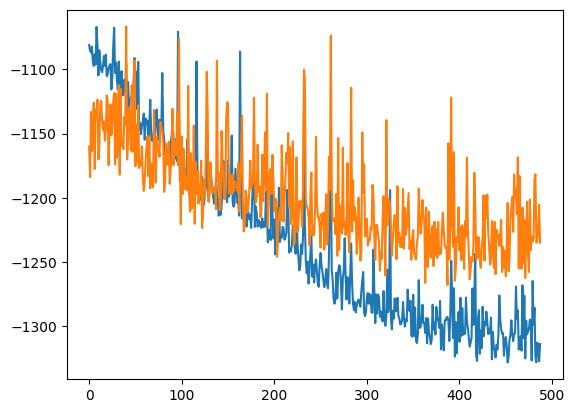

alpha 0.2 default_lr 0.0005


In [14]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    plt.plot(train_curve1)
    plt.plot(valid_curve1)
    plt.show()
    print("alpha",alpha, "default_lr", default_lr)

In [15]:
# iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# simdata0a = copy.deepcopy(iwvi.simenv_rolloutdata)
# iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# simdata0b = copy.deepcopy(iwvi.simenv_rolloutdata)
# # iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# # simdata0c = copy.deepcopy(iwvi.simenv_rolloutdata)



In [16]:
print(datetime.datetime.now())

2023-07-24 06:53:08.415295


# Iter2

In [17]:
policy_evaluation_iter=1

In [18]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    iwvi.get_sim_rollout_bamdppolicy_data_randomstop()


 0

 1

 2

 3

 4

 5

 6

 7

 8

 9

 10

 11

 12

 13

 14

 15

 16

 17

 18

 19

 20

 21

 22

 23

 24

 25

 26

 27

 28

 29

 30

 31

 32

 33

 34

 35

 36

 37

 38

 39

 40

 41

 42

 43

 44

 45

 46

 47

 48

 49

 50

 51

 52

 53

 54

 55

 56

 57

 58

 59

 60

 61

 62

 63

 64

 65

 66

 67

 68

 69

 70

 71

 72

 73

 74

 75

 76

 77

 78

 79

 80

 81

 82

 83

 84

 85

 86

 87

 88

 89

 90

 91

 92

 93

 94

 95

 96

 97

 98

 99
 


In [19]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    iwvi.train_ratio(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, policy=agent.select_action)


train: iter 0  trainloss 1.26957  validloss 1.60245±0.00000  bestvalidloss 1.60245  last_update 0
train: iter 1  trainloss 0.96077  validloss 1.03670±0.00000  bestvalidloss 1.03670  last_update 0
train: iter 2  trainloss 0.88588  validloss 0.98292±0.00000  bestvalidloss 0.98292  last_update 0
train: iter 3  trainloss 0.85043  validloss 0.99552±0.00000  bestvalidloss 0.98292  last_update 1
train: iter 4  trainloss 0.82937  validloss 0.96749±0.00000  bestvalidloss 0.96749  last_update 0
train: iter 5  trainloss 0.81544  validloss 0.94210±0.00000  bestvalidloss 0.94210  last_update 0
train: iter 6  trainloss 0.79897  validloss 0.94446±0.00000  bestvalidloss 0.94210  last_update 1
train: iter 7  trainloss 0.78823  validloss 0.93723±0.00000  bestvalidloss 0.93723  last_update 0
train: iter 8  trainloss 0.78184  validloss 0.96433±0.00000  bestvalidloss 0.93723  last_update 1
train: iter 9  trainloss 0.77925  validloss 0.92930±0.00000  bestvalidloss 0.92930  last_update 0
train: iter 10  trai

train: iter 83  trainloss 0.65514  validloss 0.85746±0.00000  bestvalidloss 0.83301  last_update 10
train: iter 84  trainloss 0.65900  validloss 0.84808±0.00000  bestvalidloss 0.83301  last_update 11
train: iter 85  trainloss 0.65593  validloss 0.84723±0.00000  bestvalidloss 0.83301  last_update 12
train: iter 86  trainloss 0.64995  validloss 0.83887±0.00000  bestvalidloss 0.83301  last_update 13
train: iter 87  trainloss 0.65467  validloss 0.85369±0.00000  bestvalidloss 0.83301  last_update 14
train: iter 88  trainloss 0.65380  validloss 0.86277±0.00000  bestvalidloss 0.83301  last_update 15
train: iter 89  trainloss 0.65867  validloss 0.84381±0.00000  bestvalidloss 0.83301  last_update 16
train: iter 90  trainloss 0.65374  validloss 0.85579±0.00000  bestvalidloss 0.83301  last_update 17
train: iter 91  trainloss 0.65234  validloss 0.83892±0.00000  bestvalidloss 0.83301  last_update 18
train: iter 92  trainloss 0.64819  validloss 0.83101±0.00000  bestvalidloss 0.83101  last_update 0
t

train: iter 165  trainloss 0.61467  validloss 0.80016±0.00000  bestvalidloss 0.80016  last_update 0
train: iter 166  trainloss 0.61896  validloss 0.82722±0.00000  bestvalidloss 0.80016  last_update 1
train: iter 167  trainloss 0.60633  validloss 0.82446±0.00000  bestvalidloss 0.80016  last_update 2
train: iter 168  trainloss 0.61494  validloss 0.83724±0.00000  bestvalidloss 0.80016  last_update 3
train: iter 169  trainloss 0.61005  validloss 0.83448±0.00000  bestvalidloss 0.80016  last_update 4
train: iter 170  trainloss 0.61498  validloss 0.81323±0.00000  bestvalidloss 0.80016  last_update 5
train: iter 171  trainloss 0.61369  validloss 0.81653±0.00000  bestvalidloss 0.80016  last_update 6
train: iter 172  trainloss 0.60977  validloss 0.81756±0.00000  bestvalidloss 0.80016  last_update 7
train: iter 173  trainloss 0.61092  validloss 0.81255±0.00000  bestvalidloss 0.80016  last_update 8
train: iter 174  trainloss 0.61316  validloss 0.83584±0.00000  bestvalidloss 0.80016  last_update 9


train: iter 247  trainloss 0.59952  validloss 0.84629±0.00000  bestvalidloss 0.79133  last_update 1
train: iter 248  trainloss 0.58316  validloss 0.81293±0.00000  bestvalidloss 0.79133  last_update 2
train: iter 249  trainloss 0.58603  validloss 0.80084±0.00000  bestvalidloss 0.79133  last_update 3
train: iter 250  trainloss 0.58512  validloss 0.80330±0.00000  bestvalidloss 0.79133  last_update 4
train: iter 251  trainloss 0.58006  validloss 0.80676±0.00000  bestvalidloss 0.79133  last_update 5
train: iter 252  trainloss 0.58479  validloss 0.80988±0.00000  bestvalidloss 0.79133  last_update 6
train: iter 253  trainloss 0.58350  validloss 0.80519±0.00000  bestvalidloss 0.79133  last_update 7
train: iter 254  trainloss 0.58562  validloss 0.82396±0.00000  bestvalidloss 0.79133  last_update 8
train: iter 255  trainloss 0.58400  validloss 0.79654±0.00000  bestvalidloss 0.79133  last_update 9
train: iter 256  trainloss 0.59186  validloss 0.80207±0.00000  bestvalidloss 0.79133  last_update 10

train: iter 329  trainloss 0.56643  validloss 0.79286±0.00000  bestvalidloss 0.78627  last_update 38
train: iter 330  trainloss 0.56135  validloss 0.81050±0.00000  bestvalidloss 0.78627  last_update 39
train: iter 331  trainloss 0.56368  validloss 0.79526±0.00000  bestvalidloss 0.78627  last_update 40
train: iter 332  trainloss 0.57236  validloss 0.81862±0.00000  bestvalidloss 0.78627  last_update 41
train: iter 333  trainloss 0.57384  validloss 0.81407±0.00000  bestvalidloss 0.78627  last_update 42
train: iter 334  trainloss 0.56678  validloss 0.79931±0.00000  bestvalidloss 0.78627  last_update 43
train: iter 335  trainloss 0.56158  validloss 0.81273±0.00000  bestvalidloss 0.78627  last_update 44
train: iter 336  trainloss 0.56951  validloss 0.82502±0.00000  bestvalidloss 0.78627  last_update 45
train: iter 337  trainloss 0.57231  validloss 0.79750±0.00000  bestvalidloss 0.78627  last_update 46
train: iter 338  trainloss 0.56856  validloss 0.80850±0.00000  bestvalidloss 0.78627  last_

train: iter 411  trainloss 0.54911  validloss 0.80769±0.00000  bestvalidloss 0.77976  last_update 44
train: iter 412  trainloss 0.55230  validloss 0.81223±0.00000  bestvalidloss 0.77976  last_update 45
train: iter 413  trainloss 0.55060  validloss 0.82447±0.00000  bestvalidloss 0.77976  last_update 46
train: iter 414  trainloss 0.54790  validloss 0.82036±0.00000  bestvalidloss 0.77976  last_update 47
train: iter 415  trainloss 0.55055  validloss 0.83531±0.00000  bestvalidloss 0.77976  last_update 48
train: iter 416  trainloss 0.54494  validloss 0.81179±0.00000  bestvalidloss 0.77976  last_update 49
train: iter 417  trainloss 0.54540  validloss 0.80644±0.00000  bestvalidloss 0.77976  last_update 50
train: iter 418  trainloss 0.54933  validloss 0.80395±0.00000  bestvalidloss 0.77976  last_update 51
train: iter 419  trainloss 0.54673  validloss 0.81005±0.00000  bestvalidloss 0.77976  last_update 52
train: iter 420  trainloss 0.55072  validloss 0.80312±0.00000  bestvalidloss 0.77976  last_

In [20]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    loss_list.append(iwvi.eval_loss(weight_alpha=1.))
    normalized_loss_list.append(iwvi.eval_loss(weight_alpha=alpha))


train_loss:  -5.763301740255953
valid_loss:  -14.853936820006368
weight_alpha 1.0 h_min_tilde -12.323606 ell_tilde -7.581428756206036 kappa_tilde 0.00045920978132167546
train_loss:  -5.327626623535157
valid_loss:  -5.848083727264404
weight_alpha 0.2 h_min_tilde -12.323606 ell_tilde -5.431718044281006 kappa_tilde 0.0003809174868980747


In [21]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    train_curve1, valid_curve1 = iwvi.train_weighted_vae(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, weight_alpha=alpha, flag=1)
    iwvi.update_mulogvar_offlinedata()


weight_alpha 0.2
train_weighted_vae: enc_dec
train: iter 0  trainloss -1052.01838  validloss -1168.81340±0.00000  bestvalidloss -1168.81340  last_update 0
train: iter 1  trainloss -1065.43974  validloss -1187.33254±0.00000  bestvalidloss -1187.33254  last_update 0
train: iter 2  trainloss -1044.05670  validloss -1224.98122±0.00000  bestvalidloss -1224.98122  last_update 0
train: iter 3  trainloss -1045.01175  validloss -1141.78201±0.00000  bestvalidloss -1224.98122  last_update 1
train: iter 4  trainloss -1057.37415  validloss -1229.58848±0.00000  bestvalidloss -1229.58848  last_update 0
train: iter 5  trainloss -1058.75555  validloss -1225.33275±0.00000  bestvalidloss -1229.58848  last_update 1
train: iter 6  trainloss -1048.15159  validloss -1168.56294±0.00000  bestvalidloss -1229.58848  last_update 2
train: iter 7  trainloss -1065.17409  validloss -1204.35683±0.00000  bestvalidloss -1229.58848  last_update 3
train: iter 8  trainloss -1065.30599  validloss -1219.31964±0.00000  bestva

train: iter 74  trainloss -1130.37468  validloss -1232.31183±0.00000  bestvalidloss -1282.67559  last_update 19
train: iter 75  trainloss -1120.10533  validloss -1269.71706±0.00000  bestvalidloss -1282.67559  last_update 20
train: iter 76  trainloss -1107.96215  validloss -1193.12081±0.00000  bestvalidloss -1282.67559  last_update 21
train: iter 77  trainloss -1129.61105  validloss -1221.45127±0.00000  bestvalidloss -1282.67559  last_update 22
train: iter 78  trainloss -1130.79221  validloss -1249.52044±0.00000  bestvalidloss -1282.67559  last_update 23
train: iter 79  trainloss -1130.40179  validloss -1279.77907±0.00000  bestvalidloss -1282.67559  last_update 24
train: iter 80  trainloss -1124.33545  validloss -1240.07412±0.00000  bestvalidloss -1282.67559  last_update 25
train: iter 81  trainloss -1119.42195  validloss -1228.28374±0.00000  bestvalidloss -1282.67559  last_update 26
train: iter 82  trainloss -1111.84047  validloss -1191.79870±0.00000  bestvalidloss -1282.67559  last_up

train: iter 147  trainloss -1121.88150  validloss -1303.37990±0.00000  bestvalidloss -1334.94918  last_update 2
train: iter 148  trainloss -1172.01960  validloss -1246.56867±0.00000  bestvalidloss -1334.94918  last_update 3
train: iter 149  trainloss -1187.51238  validloss -1314.00710±0.00000  bestvalidloss -1334.94918  last_update 4
train: iter 150  trainloss -1176.18903  validloss -1300.93485±0.00000  bestvalidloss -1334.94918  last_update 5
train: iter 151  trainloss -1188.46158  validloss -1296.75513±0.00000  bestvalidloss -1334.94918  last_update 6
train: iter 152  trainloss -1173.36580  validloss -1256.17687±0.00000  bestvalidloss -1334.94918  last_update 7
train: iter 153  trainloss -1160.40989  validloss -1273.42469±0.00000  bestvalidloss -1334.94918  last_update 8
train: iter 154  trainloss -1162.16365  validloss -1309.57348±0.00000  bestvalidloss -1334.94918  last_update 9
train: iter 155  trainloss -1186.61116  validloss -1304.53805±0.00000  bestvalidloss -1334.94918  last_u

train: iter 220  trainloss -1205.87555  validloss -1263.66386±0.00000  bestvalidloss -1359.18543  last_update 21
train: iter 221  trainloss -1242.11222  validloss -1354.71612±0.00000  bestvalidloss -1359.18543  last_update 22
train: iter 222  trainloss -1240.48918  validloss -1302.43617±0.00000  bestvalidloss -1359.18543  last_update 23
train: iter 223  trainloss -1241.52541  validloss -1291.82897±0.00000  bestvalidloss -1359.18543  last_update 24
train: iter 224  trainloss -1235.24050  validloss -1373.05865±0.00000  bestvalidloss -1373.05865  last_update 0
train: iter 225  trainloss -1249.20118  validloss -1350.58809±0.00000  bestvalidloss -1373.05865  last_update 1
train: iter 226  trainloss -1236.12034  validloss -1292.23780±0.00000  bestvalidloss -1373.05865  last_update 2
train: iter 227  trainloss -1252.41782  validloss -1394.90070±0.00000  bestvalidloss -1394.90070  last_update 0
train: iter 228  trainloss -1248.99402  validloss -1271.82461±0.00000  bestvalidloss -1394.90070  la

train: iter 293  trainloss -1277.35024  validloss -1365.87605±0.00000  bestvalidloss -1398.40389  last_update 1
train: iter 294  trainloss -1288.87405  validloss -1377.22588±0.00000  bestvalidloss -1398.40389  last_update 2
train: iter 295  trainloss -1272.34109  validloss -1346.64912±0.00000  bestvalidloss -1398.40389  last_update 3
train: iter 296  trainloss -1263.13343  validloss -1288.22266±0.00000  bestvalidloss -1398.40389  last_update 4
train: iter 297  trainloss -1275.23318  validloss -1403.95220±0.00000  bestvalidloss -1403.95220  last_update 0
train: iter 298  trainloss -1291.24451  validloss -1381.03205±0.00000  bestvalidloss -1403.95220  last_update 1
train: iter 299  trainloss -1285.20135  validloss -1380.47345±0.00000  bestvalidloss -1403.95220  last_update 2
train: iter 300  trainloss -1286.34318  validloss -1364.96630±0.00000  bestvalidloss -1403.95220  last_update 3
train: iter 301  trainloss -1296.63804  validloss -1358.39531±0.00000  bestvalidloss -1403.95220  last_u

train: iter 366  trainloss -1327.99192  validloss -1344.13532±0.00000  bestvalidloss -1437.02417  last_update 1
train: iter 367  trainloss -1328.67153  validloss -1376.71992±0.00000  bestvalidloss -1437.02417  last_update 2
train: iter 368  trainloss -1325.08579  validloss -1374.19662±0.00000  bestvalidloss -1437.02417  last_update 3
train: iter 369  trainloss -1324.06500  validloss -1384.06362±0.00000  bestvalidloss -1437.02417  last_update 4
train: iter 370  trainloss -1324.54844  validloss -1335.39809±0.00000  bestvalidloss -1437.02417  last_update 5
train: iter 371  trainloss -1318.62653  validloss -1331.23493±0.00000  bestvalidloss -1437.02417  last_update 6
train: iter 372  trainloss -1306.61627  validloss -1332.56481±0.00000  bestvalidloss -1437.02417  last_update 7
train: iter 373  trainloss -1318.90677  validloss -1400.75364±0.00000  bestvalidloss -1437.02417  last_update 8
train: iter 374  trainloss -1325.00904  validloss -1367.51816±0.00000  bestvalidloss -1437.02417  last_u

train: iter 439  trainloss -1363.15435  validloss -1409.34203±0.00000  bestvalidloss -1459.83115  last_update 49
train: iter 440  trainloss -1371.65410  validloss -1378.05680±0.00000  bestvalidloss -1459.83115  last_update 50
train: iter 441  trainloss -1353.19389  validloss -1391.48234±0.00000  bestvalidloss -1459.83115  last_update 51
train: iter 442  trainloss -1359.53003  validloss -1399.94581±0.00000  bestvalidloss -1459.83115  last_update 52
train: iter 443  trainloss -1352.14153  validloss -1365.05767±0.00000  bestvalidloss -1459.83115  last_update 53
train: iter 444  trainloss -1349.43746  validloss -1424.21936±0.00000  bestvalidloss -1459.83115  last_update 54
train: iter 445  trainloss -1362.58624  validloss -1376.81070±0.00000  bestvalidloss -1459.83115  last_update 55
train: iter 446  trainloss -1359.34291  validloss -1355.37322±0.00000  bestvalidloss -1459.83115  last_update 56
train: iter 447  trainloss -1373.67072  validloss -1399.74544±0.00000  bestvalidloss -1459.83115

train: iter 512  trainloss -1401.13759  validloss -1466.05938±0.00000  bestvalidloss -1486.16628  last_update 39
train: iter 513  trainloss -1401.85028  validloss -1441.03356±0.00000  bestvalidloss -1486.16628  last_update 40
train: iter 514  trainloss -1389.12580  validloss -1415.66704±0.00000  bestvalidloss -1486.16628  last_update 41
train: iter 515  trainloss -1403.77648  validloss -1417.06230±0.00000  bestvalidloss -1486.16628  last_update 42
train: iter 516  trainloss -1409.05521  validloss -1447.16059±0.00000  bestvalidloss -1486.16628  last_update 43
train: iter 517  trainloss -1404.06698  validloss -1472.59899±0.00000  bestvalidloss -1486.16628  last_update 44
train: iter 518  trainloss -1397.58870  validloss -1402.03777±0.00000  bestvalidloss -1486.16628  last_update 45
train: iter 519  trainloss -1413.18706  validloss -1460.01552±0.00000  bestvalidloss -1486.16628  last_update 46
train: iter 520  trainloss -1407.54649  validloss -1491.97391±0.00000  bestvalidloss -1491.97391

train: iter 585  trainloss -1425.00671  validloss -1515.18261±0.00000  bestvalidloss -1515.18261  last_update 0
train: iter 586  trainloss -1428.54597  validloss -1428.14338±0.00000  bestvalidloss -1515.18261  last_update 1
train: iter 587  trainloss -1438.70987  validloss -1501.70503±0.00000  bestvalidloss -1515.18261  last_update 2
train: iter 588  trainloss -1396.33241  validloss -1492.31976±0.00000  bestvalidloss -1515.18261  last_update 3
train: iter 589  trainloss -1426.30229  validloss -1411.09914±0.00000  bestvalidloss -1515.18261  last_update 4
train: iter 590  trainloss -1437.52769  validloss -1464.28069±0.00000  bestvalidloss -1515.18261  last_update 5
train: iter 591  trainloss -1438.93093  validloss -1423.24004±0.00000  bestvalidloss -1515.18261  last_update 6
train: iter 592  trainloss -1435.65922  validloss -1434.04429±0.00000  bestvalidloss -1515.18261  last_update 7
train: iter 593  trainloss -1431.91576  validloss -1397.37797±0.00000  bestvalidloss -1515.18261  last_u

train: iter 658  trainloss -1459.02691  validloss -1430.68050±0.00000  bestvalidloss -1544.22383  last_update 24
train: iter 659  trainloss -1445.83705  validloss -1459.33305±0.00000  bestvalidloss -1544.22383  last_update 25
train: iter 660  trainloss -1467.19672  validloss -1474.32283±0.00000  bestvalidloss -1544.22383  last_update 26
train: iter 661  trainloss -1458.41584  validloss -1488.25769±0.00000  bestvalidloss -1544.22383  last_update 27
train: iter 662  trainloss -1465.41491  validloss -1526.37088±0.00000  bestvalidloss -1544.22383  last_update 28
train: iter 663  trainloss -1456.74568  validloss -1507.11903±0.00000  bestvalidloss -1544.22383  last_update 29
train: iter 664  trainloss -1466.74671  validloss -1479.50438±0.00000  bestvalidloss -1544.22383  last_update 30
train: iter 665  trainloss -1465.37991  validloss -1465.95687±0.00000  bestvalidloss -1544.22383  last_update 31
train: iter 666  trainloss -1461.29612  validloss -1449.07854±0.00000  bestvalidloss -1544.22383

train: iter 731  trainloss -1459.45609  validloss -1464.25960±0.00000  bestvalidloss -1544.22383  last_update 97
train: iter 732  trainloss -1483.72183  validloss -1517.02548±0.00000  bestvalidloss -1544.22383  last_update 98
train: iter 733  trainloss -1482.28301  validloss -1455.46683±0.00000  bestvalidloss -1544.22383  last_update 99
train: iter 734  trainloss -1474.39316  validloss -1483.85539±0.00000  bestvalidloss -1544.22383  last_update 100
train: fin
penalty_target_min tensor(-12.3237) penalty_target_max tensor(33.0571)


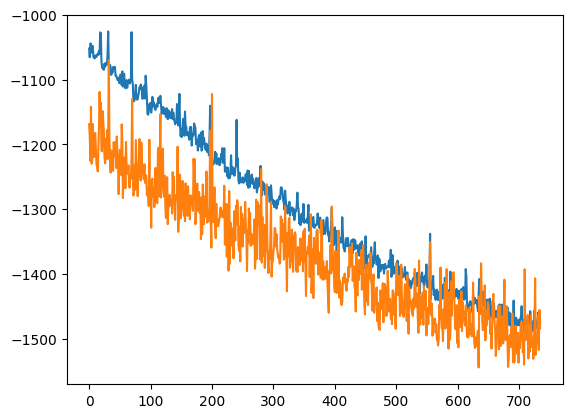

alpha 0.2 default_lr 0.0005


In [22]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    plt.plot(train_curve1)
    plt.plot(valid_curve1)
    plt.show()
print("alpha",alpha, "default_lr", default_lr)

In [23]:
# iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# simdata0a = copy.deepcopy(iwvi.simenv_rolloutdata)
# iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# simdata0b = copy.deepcopy(iwvi.simenv_rolloutdata)
# # iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# # simdata0c = copy.deepcopy(iwvi.simenv_rolloutdata)


In [24]:
print(datetime.datetime.now())

2023-07-24 07:20:55.019035


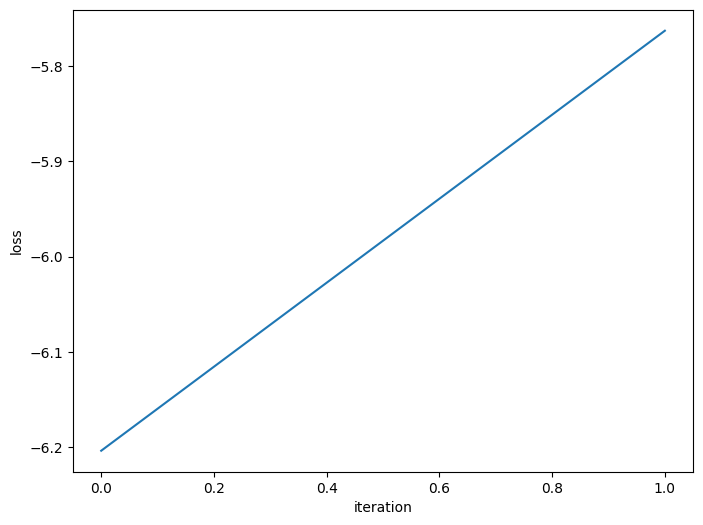

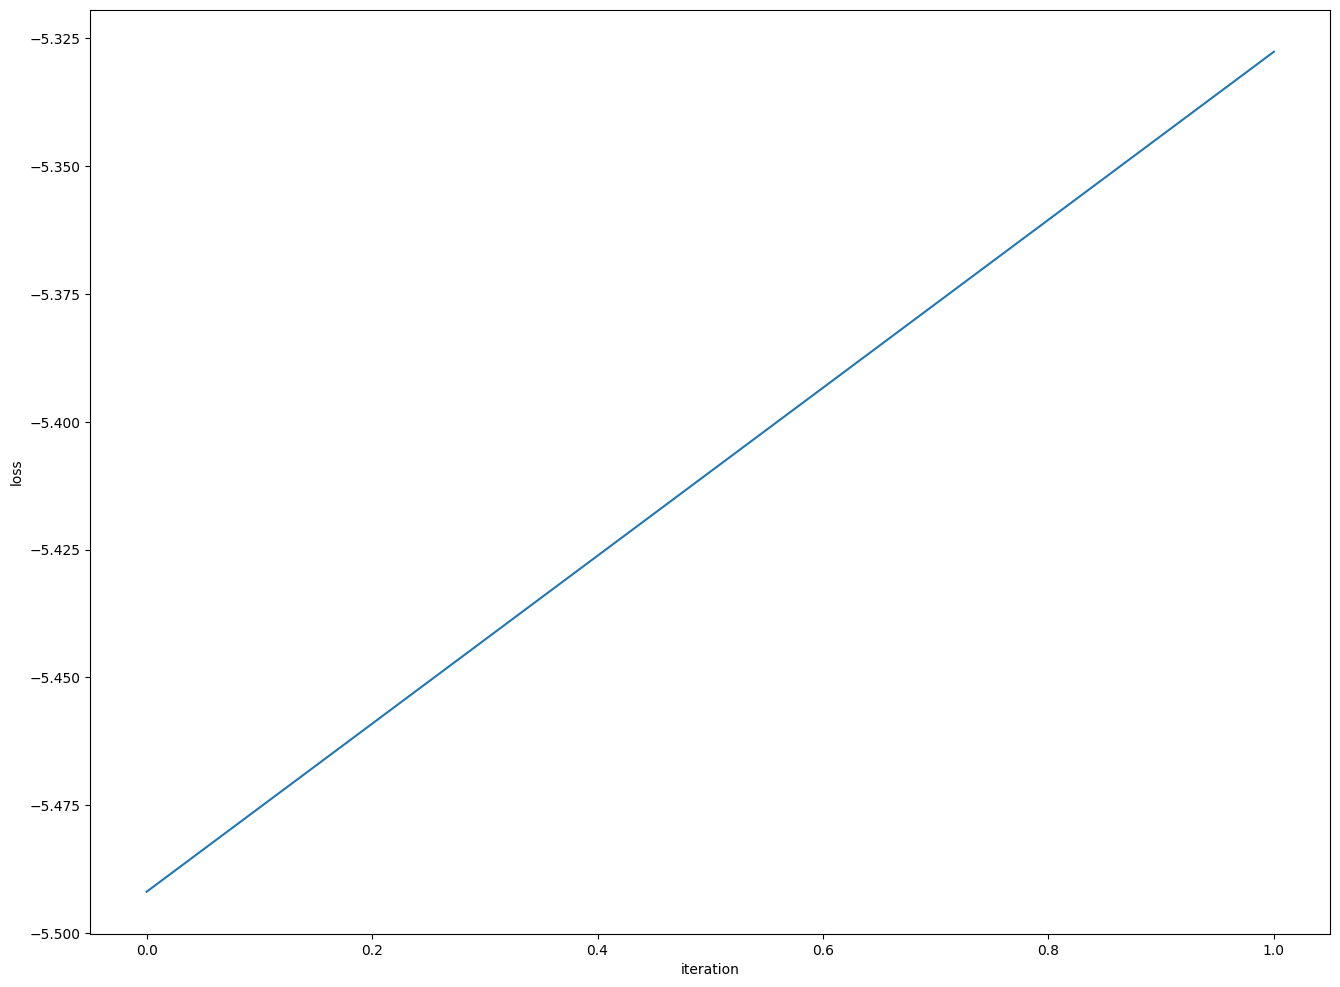

In [25]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    loss_array = np.array(loss_list)
    plt.figure(figsize=(8,6))
    plt.plot(loss_array[:,0])
    plt.xlabel("iteration")
    plt.ylabel("loss")
    plt.show()
    
    normalized_loss_array = np.array(normalized_loss_list)
    plt.figure(figsize=(8,6))
    plt.plot(normalized_loss_array[:,0])
    plt.xlabel("iteration")
    plt.ylabel("loss")

In [26]:
# if policy_evaluation_iter<policy_evaluation_maxiter:
#     normalized_loss_array = np.array(normalized_loss_list)
#     plt.figure(figsize=(16,12))
#     plt.plot(normalized_loss_array[:,0])
#     plt.xlabel("iteration")
#     plt.ylabel("loss")


# Iter 3

In [27]:
policy_evaluation_iter=2

In [28]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    iwvi.get_sim_rollout_bamdppolicy_data_randomstop()


 0

 1

 2

 3

 4

 5

 6

 7

 8

 9

 10

 11

 12

 13

 14

 15

 16

 17

 18

 19

 20

 21

 22

 23

 24
predict diverge [ 6.72130301  9.16477089 -7.5840528   3.3752493 ] [0.13282303 0.59657961 0.04958195 0.56209072] [22.259691  8.68547  55.24954  21.237312] [11.129846  4.342735 27.62477  10.618656] sim_timestep 136

 25
predict diverge [ 7.52376175  9.1982526  -7.13807892  5.91631669] [0.13123986 0.73672244 0.06232206 0.62575813] [22.259691  8.68547  55.24954  21.237312] [11.129846  4.342735 27.62477  10.618656] sim_timestep 124

 26

 27

 28

 29

 30

 31

 32

 33

 34

 35

 36

 37

 38

 39

 40

 41

 42

 43

 44

 45

 46

 47

 48

 49

 50

 51

 52

 53

 54

 55

 56

 57

 58

 59

 60

 61

 62

 63

 64

 65

 66

 67

 68

 69

 70

 71

 72

 73

 74

 75

 76

 77

 78

 79

 80

 81

 82

 83

 84

 85

 86

 87

 88

 89

 90

 91

 92

 93

 94

 95

 96

 97

 98

 99
 


In [29]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    iwvi.train_ratio(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, policy=agent.select_action)


train: iter 0  trainloss 0.87446  validloss 1.35342±0.00000  bestvalidloss 1.35342  last_update 0
train: iter 1  trainloss 0.77463  validloss 1.01685±0.00000  bestvalidloss 1.01685  last_update 0
train: iter 2  trainloss 0.74351  validloss 0.96555±0.00000  bestvalidloss 0.96555  last_update 0
train: iter 3  trainloss 0.73201  validloss 0.95009±0.00000  bestvalidloss 0.95009  last_update 0
train: iter 4  trainloss 0.72231  validloss 0.95985±0.00000  bestvalidloss 0.95009  last_update 1
train: iter 5  trainloss 0.71683  validloss 0.89751±0.00000  bestvalidloss 0.89751  last_update 0
train: iter 6  trainloss 0.70494  validloss 0.93019±0.00000  bestvalidloss 0.89751  last_update 1
train: iter 7  trainloss 0.70387  validloss 0.90940±0.00000  bestvalidloss 0.89751  last_update 2
train: iter 8  trainloss 0.70196  validloss 0.90710±0.00000  bestvalidloss 0.89751  last_update 3
train: iter 9  trainloss 0.69657  validloss 0.89827±0.00000  bestvalidloss 0.89751  last_update 4
train: iter 10  trai

train: iter 83  trainloss 0.63273  validloss 0.84628±0.00000  bestvalidloss 0.81261  last_update 4
train: iter 84  trainloss 0.62873  validloss 0.84203±0.00000  bestvalidloss 0.81261  last_update 5
train: iter 85  trainloss 0.63092  validloss 0.83720±0.00000  bestvalidloss 0.81261  last_update 6
train: iter 86  trainloss 0.63156  validloss 0.85238±0.00000  bestvalidloss 0.81261  last_update 7
train: iter 87  trainloss 0.63812  validloss 0.83039±0.00000  bestvalidloss 0.81261  last_update 8
train: iter 88  trainloss 0.63626  validloss 0.84611±0.00000  bestvalidloss 0.81261  last_update 9
train: iter 89  trainloss 0.63999  validloss 0.81207±0.00000  bestvalidloss 0.81207  last_update 0
train: iter 90  trainloss 0.62967  validloss 0.82185±0.00000  bestvalidloss 0.81207  last_update 1
train: iter 91  trainloss 0.63364  validloss 0.82290±0.00000  bestvalidloss 0.81207  last_update 2
train: iter 92  trainloss 0.62906  validloss 0.83265±0.00000  bestvalidloss 0.81207  last_update 3
train: ite

train: iter 165  trainloss 0.61293  validloss 0.80778±0.00000  bestvalidloss 0.79422  last_update 47
train: iter 166  trainloss 0.60958  validloss 0.81622±0.00000  bestvalidloss 0.79422  last_update 48
train: iter 167  trainloss 0.61573  validloss 0.83256±0.00000  bestvalidloss 0.79422  last_update 49
train: iter 168  trainloss 0.61192  validloss 0.82083±0.00000  bestvalidloss 0.79422  last_update 50
train: iter 169  trainloss 0.60770  validloss 0.82541±0.00000  bestvalidloss 0.79422  last_update 51
train: iter 170  trainloss 0.61386  validloss 0.82327±0.00000  bestvalidloss 0.79422  last_update 52
train: iter 171  trainloss 0.60638  validloss 0.82658±0.00000  bestvalidloss 0.79422  last_update 53
train: iter 172  trainloss 0.61167  validloss 0.82446±0.00000  bestvalidloss 0.79422  last_update 54
train: iter 173  trainloss 0.61255  validloss 0.82587±0.00000  bestvalidloss 0.79422  last_update 55
train: iter 174  trainloss 0.61345  validloss 0.83118±0.00000  bestvalidloss 0.79422  last_

In [30]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    loss_list.append(iwvi.eval_loss(weight_alpha=1.))
    normalized_loss_list.append(iwvi.eval_loss(weight_alpha=alpha))


train_loss:  -6.829685866457224
valid_loss:  -13.925267938423156
weight_alpha 1.0 h_min_tilde -12.3236885 ell_tilde -8.248802280850411 kappa_tilde 0.0004953843202174917
train_loss:  -5.907089901638031
valid_loss:  -6.054391079711914
weight_alpha 0.2 h_min_tilde -12.3236885 ell_tilde -5.936550137252807 kappa_tilde 0.0003956824951228528


In [31]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    train_curve1, valid_curve1 = iwvi.train_weighted_vae(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, weight_alpha=alpha, flag=1)
    iwvi.update_mulogvar_offlinedata()


weight_alpha 0.2
train_weighted_vae: enc_dec
train: iter 0  trainloss -1184.61693  validloss -1195.48711±0.00000  bestvalidloss -1195.48711  last_update 0
train: iter 1  trainloss -1185.66047  validloss -1220.97641±0.00000  bestvalidloss -1220.97641  last_update 0
train: iter 2  trainloss -1191.93905  validloss -1250.06375±0.00000  bestvalidloss -1250.06375  last_update 0
train: iter 3  trainloss -1149.17340  validloss -1203.16516±0.00000  bestvalidloss -1250.06375  last_update 1
train: iter 4  trainloss -1195.08766  validloss -1182.24654±0.00000  bestvalidloss -1250.06375  last_update 2
train: iter 5  trainloss -1188.83589  validloss -1206.65565±0.00000  bestvalidloss -1250.06375  last_update 3
train: iter 6  trainloss -1192.70908  validloss -1204.53877±0.00000  bestvalidloss -1250.06375  last_update 4
train: iter 7  trainloss -1196.07884  validloss -1230.42734±0.00000  bestvalidloss -1250.06375  last_update 5
train: iter 8  trainloss -1190.62356  validloss -1199.23304±0.00000  bestva

train: iter 74  trainloss -1202.87108  validloss -1198.14041±0.00000  bestvalidloss -1306.13055  last_update 12
train: iter 75  trainloss -1207.81336  validloss -1275.69272±0.00000  bestvalidloss -1306.13055  last_update 13
train: iter 76  trainloss -1199.24560  validloss -1255.53365±0.00000  bestvalidloss -1306.13055  last_update 14
train: iter 77  trainloss -1185.71746  validloss -1113.35051±0.00000  bestvalidloss -1306.13055  last_update 15
train: iter 78  trainloss -1212.09584  validloss -1259.81842±0.00000  bestvalidloss -1306.13055  last_update 16
train: iter 79  trainloss -1190.72880  validloss -1266.84107±0.00000  bestvalidloss -1306.13055  last_update 17
train: iter 80  trainloss -1220.17445  validloss -1240.33555±0.00000  bestvalidloss -1306.13055  last_update 18
train: iter 81  trainloss -1222.38463  validloss -1245.43820±0.00000  bestvalidloss -1306.13055  last_update 19
train: iter 82  trainloss -1218.07734  validloss -1295.31454±0.00000  bestvalidloss -1306.13055  last_up

train: iter 148  trainloss -1249.63761  validloss -1256.63156±0.00000  bestvalidloss -1325.34631  last_update 13
train: iter 149  trainloss -1254.86801  validloss -1256.00746±0.00000  bestvalidloss -1325.34631  last_update 14
train: iter 150  trainloss -1247.31976  validloss -1230.21638±0.00000  bestvalidloss -1325.34631  last_update 15
train: iter 151  trainloss -1259.72743  validloss -1262.03755±0.00000  bestvalidloss -1325.34631  last_update 16
train: iter 152  trainloss -1244.67702  validloss -1276.20506±0.00000  bestvalidloss -1325.34631  last_update 17
train: iter 153  trainloss -1247.88852  validloss -1304.63716±0.00000  bestvalidloss -1325.34631  last_update 18
train: iter 154  trainloss -1248.53104  validloss -1284.70965±0.00000  bestvalidloss -1325.34631  last_update 19
train: iter 155  trainloss -1263.94787  validloss -1264.57501±0.00000  bestvalidloss -1325.34631  last_update 20
train: iter 156  trainloss -1252.24269  validloss -1180.90696±0.00000  bestvalidloss -1325.34631

train: iter 221  trainloss -1276.37400  validloss -1292.26475±0.00000  bestvalidloss -1369.40814  last_update 8
train: iter 222  trainloss -1282.94923  validloss -1332.63152±0.00000  bestvalidloss -1369.40814  last_update 9
train: iter 223  trainloss -1272.63132  validloss -1278.33755±0.00000  bestvalidloss -1369.40814  last_update 10
train: iter 224  trainloss -1263.08348  validloss -1284.02942±0.00000  bestvalidloss -1369.40814  last_update 11
train: iter 225  trainloss -1277.65285  validloss -1328.68924±0.00000  bestvalidloss -1369.40814  last_update 12
train: iter 226  trainloss -1285.09743  validloss -1326.21707±0.00000  bestvalidloss -1369.40814  last_update 13
train: iter 227  trainloss -1278.74562  validloss -1314.82946±0.00000  bestvalidloss -1369.40814  last_update 14
train: iter 228  trainloss -1270.25538  validloss -1326.27939±0.00000  bestvalidloss -1369.40814  last_update 15
train: iter 229  trainloss -1253.74358  validloss -1293.74003±0.00000  bestvalidloss -1369.40814  

train: iter 294  trainloss -1297.98973  validloss -1275.73548±0.00000  bestvalidloss -1369.40814  last_update 81
train: iter 295  trainloss -1295.05894  validloss -1313.13934±0.00000  bestvalidloss -1369.40814  last_update 82
train: iter 296  trainloss -1298.52667  validloss -1297.85216±0.00000  bestvalidloss -1369.40814  last_update 83
train: iter 297  trainloss -1293.35737  validloss -1313.95097±0.00000  bestvalidloss -1369.40814  last_update 84
train: iter 298  trainloss -1294.73663  validloss -1317.94576±0.00000  bestvalidloss -1369.40814  last_update 85
train: iter 299  trainloss -1284.38036  validloss -1294.29050±0.00000  bestvalidloss -1369.40814  last_update 86
train: iter 300  trainloss -1276.72978  validloss -1263.56819±0.00000  bestvalidloss -1369.40814  last_update 87
train: iter 301  trainloss -1292.32276  validloss -1339.80637±0.00000  bestvalidloss -1369.40814  last_update 88
train: iter 302  trainloss -1298.28916  validloss -1299.27164±0.00000  bestvalidloss -1369.40814

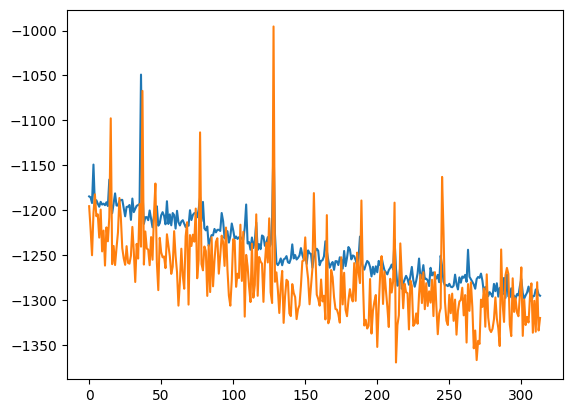

alpha 0.2 default_lr 0.0005


In [32]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    plt.plot(train_curve1)
    plt.plot(valid_curve1)
    plt.show()

print("alpha",alpha, "default_lr", default_lr)

In [33]:
# iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# simdata0a = copy.deepcopy(iwvi.simenv_rolloutdata)
# iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# simdata0b = copy.deepcopy(iwvi.simenv_rolloutdata)
# # iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# # simdata0c = copy.deepcopy(iwvi.simenv_rolloutdata)



In [34]:
print(datetime.datetime.now())

2023-07-24 07:47:44.466103


# Iter 4

In [35]:
policy_evaluation_iter=3

In [36]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    iwvi.get_sim_rollout_bamdppolicy_data_randomstop()


 0

 1

 2

 3

 4

 5

 6

 7

 8

 9

 10

 11

 12

 13

 14

 15

 16

 17

 18

 19

 20

 21

 22

 23

 24

 25

 26

 27

 28
predict diverge [-1.28879928  9.82371227 -5.33726008 13.92914981] [0.08302997 1.1568393  0.23158181 0.66224358] [22.259691  8.68547  55.24954  21.237312] [11.129846  4.342735 27.62477  10.618656] sim_timestep 78

 29

 30

 31

 32

 33

 34

 35

 36

 37

 38

 39

 40

 41

 42

 43

 44

 45

 46
predict diverge [ 0.81077618  9.12965126 -5.58339264  8.81052376] [0.07477714 0.9666142  0.15047071 0.69951559] [22.259691  8.68547  55.24954  21.237312] [11.129846  4.342735 27.62477  10.618656] sim_timestep 63

 47

 48

 49

 50

 51

 52

 53

 54

 55

 56

 57

 58

 59

 60

 61

 62

 63

 64

 65

 66

 67

 68

 69

 70

 71

 72

 73

 74

 75

 76

 77

 78

 79

 80

 81

 82

 83

 84

 85

 86

 87
predict diverge [-1.11460673  2.29919379 -3.94844788 22.99797633] [ 0.07741575 -5.10093495  0.26967405  5.59426926] [22.259691  8.68547  55.24954 

In [37]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    iwvi.train_ratio(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, policy=agent.select_action)


train: iter 0  trainloss 0.81435  validloss 1.09078±0.00000  bestvalidloss 1.09078  last_update 0
train: iter 1  trainloss 0.73938  validloss 1.04653±0.00000  bestvalidloss 1.04653  last_update 0
train: iter 2  trainloss 0.72451  validloss 0.95135±0.00000  bestvalidloss 0.95135  last_update 0
train: iter 3  trainloss 0.70775  validloss 0.92024±0.00000  bestvalidloss 0.92024  last_update 0
train: iter 4  trainloss 0.69701  validloss 0.95193±0.00000  bestvalidloss 0.92024  last_update 1
train: iter 5  trainloss 0.69282  validloss 0.88605±0.00000  bestvalidloss 0.88605  last_update 0
train: iter 6  trainloss 0.68622  validloss 0.89767±0.00000  bestvalidloss 0.88605  last_update 1
train: iter 7  trainloss 0.68472  validloss 0.90863±0.00000  bestvalidloss 0.88605  last_update 2
train: iter 8  trainloss 0.68026  validloss 0.88295±0.00000  bestvalidloss 0.88295  last_update 0
train: iter 9  trainloss 0.67938  validloss 0.87941±0.00000  bestvalidloss 0.87941  last_update 0
train: iter 10  trai

train: iter 83  trainloss 0.62432  validloss 0.89353±0.00000  bestvalidloss 0.84629  last_update 3
train: iter 84  trainloss 0.62733  validloss 0.89721±0.00000  bestvalidloss 0.84629  last_update 4
train: iter 85  trainloss 0.62023  validloss 0.83643±0.00000  bestvalidloss 0.83643  last_update 0
train: iter 86  trainloss 0.63041  validloss 0.87835±0.00000  bestvalidloss 0.83643  last_update 1
train: iter 87  trainloss 0.62123  validloss 0.88792±0.00000  bestvalidloss 0.83643  last_update 2
train: iter 88  trainloss 0.61716  validloss 0.85321±0.00000  bestvalidloss 0.83643  last_update 3
train: iter 89  trainloss 0.61618  validloss 0.88229±0.00000  bestvalidloss 0.83643  last_update 4
train: iter 90  trainloss 0.62539  validloss 0.85787±0.00000  bestvalidloss 0.83643  last_update 5
train: iter 91  trainloss 0.62008  validloss 0.84860±0.00000  bestvalidloss 0.83643  last_update 6
train: iter 92  trainloss 0.61917  validloss 0.83121±0.00000  bestvalidloss 0.83121  last_update 0
train: ite

train: iter 165  trainloss 0.60019  validloss 0.86135±0.00000  bestvalidloss 0.81938  last_update 4
train: iter 166  trainloss 0.60440  validloss 0.91867±0.00000  bestvalidloss 0.81938  last_update 5
train: iter 167  trainloss 0.60268  validloss 0.83211±0.00000  bestvalidloss 0.81938  last_update 6
train: iter 168  trainloss 0.60928  validloss 0.88373±0.00000  bestvalidloss 0.81938  last_update 7
train: iter 169  trainloss 0.60066  validloss 0.85790±0.00000  bestvalidloss 0.81938  last_update 8
train: iter 170  trainloss 0.60284  validloss 0.89640±0.00000  bestvalidloss 0.81938  last_update 9
train: iter 171  trainloss 0.60522  validloss 0.83910±0.00000  bestvalidloss 0.81938  last_update 10
train: iter 172  trainloss 0.60042  validloss 0.87429±0.00000  bestvalidloss 0.81938  last_update 11
train: iter 173  trainloss 0.59596  validloss 0.89552±0.00000  bestvalidloss 0.81938  last_update 12
train: iter 174  trainloss 0.60302  validloss 0.83311±0.00000  bestvalidloss 0.81938  last_update

train: iter 247  trainloss 0.59107  validloss 0.85186±0.00000  bestvalidloss 0.81938  last_update 86
train: iter 248  trainloss 0.58459  validloss 0.86163±0.00000  bestvalidloss 0.81938  last_update 87
train: iter 249  trainloss 0.59043  validloss 0.88495±0.00000  bestvalidloss 0.81938  last_update 88
train: iter 250  trainloss 0.58335  validloss 0.85792±0.00000  bestvalidloss 0.81938  last_update 89
train: iter 251  trainloss 0.58036  validloss 0.86691±0.00000  bestvalidloss 0.81938  last_update 90
train: iter 252  trainloss 0.58255  validloss 0.83781±0.00000  bestvalidloss 0.81938  last_update 91
train: iter 253  trainloss 0.58627  validloss 0.88242±0.00000  bestvalidloss 0.81938  last_update 92
train: iter 254  trainloss 0.57978  validloss 0.89186±0.00000  bestvalidloss 0.81938  last_update 93
train: iter 255  trainloss 0.58043  validloss 0.87308±0.00000  bestvalidloss 0.81938  last_update 94
train: iter 256  trainloss 0.58187  validloss 0.83334±0.00000  bestvalidloss 0.81938  last_

In [38]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    loss_list.append(iwvi.eval_loss(weight_alpha=1.))
    normalized_loss_list.append(iwvi.eval_loss(weight_alpha=alpha))


train_loss:  -7.327730940425395
valid_loss:  -15.368225371837614
weight_alpha 1.0 h_min_tilde -12.317137 ell_tilde -8.935829826707838 kappa_tilde 0.00054382316387614
train_loss:  -5.975954121303558
valid_loss:  -6.0022367469787605
weight_alpha 0.2 h_min_tilde -12.317137 ell_tilde -5.981210646438599 kappa_tilde 0.00039727839512230254


In [39]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    train_curve1, valid_curve1 = iwvi.train_weighted_vae(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, weight_alpha=alpha, flag=1)
    iwvi.update_mulogvar_offlinedata()


weight_alpha 0.2
train_weighted_vae: enc_dec
train: iter 0  trainloss -1170.22170  validloss -1197.06093±0.00000  bestvalidloss -1197.06093  last_update 0
train: iter 1  trainloss -1191.82016  validloss -1203.16219±0.00000  bestvalidloss -1203.16219  last_update 0
train: iter 2  trainloss -1203.64476  validloss -1220.71848±0.00000  bestvalidloss -1220.71848  last_update 0
train: iter 3  trainloss -1196.85090  validloss -1214.04139±0.00000  bestvalidloss -1220.71848  last_update 1
train: iter 4  trainloss -1193.84213  validloss -1182.26485±0.00000  bestvalidloss -1220.71848  last_update 2
train: iter 5  trainloss -1174.62333  validloss -1250.18280±0.00000  bestvalidloss -1250.18280  last_update 0
train: iter 6  trainloss -1190.57036  validloss -1156.28004±0.00000  bestvalidloss -1250.18280  last_update 1
train: iter 7  trainloss -1191.61746  validloss -1201.44011±0.00000  bestvalidloss -1250.18280  last_update 2
train: iter 8  trainloss -1200.23466  validloss -1188.05836±0.00000  bestva

train: iter 74  trainloss -1288.29326  validloss -1310.58660±0.00000  bestvalidloss -1310.58660  last_update 0
train: iter 75  trainloss -1280.71301  validloss -1334.09809±0.00000  bestvalidloss -1334.09809  last_update 0
train: iter 76  trainloss -1271.20820  validloss -1294.17386±0.00000  bestvalidloss -1334.09809  last_update 1
train: iter 77  trainloss -1298.96726  validloss -1295.07045±0.00000  bestvalidloss -1334.09809  last_update 2
train: iter 78  trainloss -1285.12045  validloss -1292.34819±0.00000  bestvalidloss -1334.09809  last_update 3
train: iter 79  trainloss -1276.48904  validloss -1267.77157±0.00000  bestvalidloss -1334.09809  last_update 4
train: iter 80  trainloss -1273.63468  validloss -1312.93504±0.00000  bestvalidloss -1334.09809  last_update 5
train: iter 81  trainloss -1268.73950  validloss -1290.72166±0.00000  bestvalidloss -1334.09809  last_update 6
train: iter 82  trainloss -1276.89563  validloss -1282.94234±0.00000  bestvalidloss -1334.09809  last_update 7
t

train: iter 147  trainloss -1300.42581  validloss -1139.23546±0.00000  bestvalidloss -1337.69146  last_update 8
train: iter 148  trainloss -1347.25314  validloss -1319.68992±0.00000  bestvalidloss -1337.69146  last_update 9
train: iter 149  trainloss -1347.14650  validloss -1363.35282±0.00000  bestvalidloss -1363.35282  last_update 0
train: iter 150  trainloss -1340.78738  validloss -1302.19880±0.00000  bestvalidloss -1363.35282  last_update 1
train: iter 151  trainloss -1335.66760  validloss -1337.76084±0.00000  bestvalidloss -1363.35282  last_update 2
train: iter 152  trainloss -1343.91320  validloss -1317.93090±0.00000  bestvalidloss -1363.35282  last_update 3
train: iter 153  trainloss -1335.06898  validloss -1314.68576±0.00000  bestvalidloss -1363.35282  last_update 4
train: iter 154  trainloss -1337.19164  validloss -1340.85132±0.00000  bestvalidloss -1363.35282  last_update 5
train: iter 155  trainloss -1332.79261  validloss -1362.38374±0.00000  bestvalidloss -1363.35282  last_u

train: iter 220  trainloss -1308.81833  validloss -1167.92888±0.00000  bestvalidloss -1384.26466  last_update 37
train: iter 221  trainloss -1357.51497  validloss -1318.78935±0.00000  bestvalidloss -1384.26466  last_update 38
train: iter 222  trainloss -1361.90868  validloss -1371.42247±0.00000  bestvalidloss -1384.26466  last_update 39
train: iter 223  trainloss -1367.12476  validloss -1252.13522±0.00000  bestvalidloss -1384.26466  last_update 40
train: iter 224  trainloss -1354.97851  validloss -1364.04024±0.00000  bestvalidloss -1384.26466  last_update 41
train: iter 225  trainloss -1343.96516  validloss -1272.66675±0.00000  bestvalidloss -1384.26466  last_update 42
train: iter 226  trainloss -1362.12272  validloss -1252.44789±0.00000  bestvalidloss -1384.26466  last_update 43
train: iter 227  trainloss -1373.19279  validloss -1340.65218±0.00000  bestvalidloss -1384.26466  last_update 44
train: iter 228  trainloss -1364.98117  validloss -1362.78876±0.00000  bestvalidloss -1384.26466

train: iter 293  trainloss -1418.45895  validloss -1398.87390±0.00000  bestvalidloss -1416.70769  last_update 16
train: iter 294  trainloss -1408.09494  validloss -1341.72562±0.00000  bestvalidloss -1416.70769  last_update 17
train: iter 295  trainloss -1405.14823  validloss -1394.01733±0.00000  bestvalidloss -1416.70769  last_update 18
train: iter 296  trainloss -1396.81284  validloss -1423.38532±0.00000  bestvalidloss -1423.38532  last_update 0
train: iter 297  trainloss -1402.73834  validloss -1389.83170±0.00000  bestvalidloss -1423.38532  last_update 1
train: iter 298  trainloss -1400.91237  validloss -1371.11931±0.00000  bestvalidloss -1423.38532  last_update 2
train: iter 299  trainloss -1413.21182  validloss -1397.89205±0.00000  bestvalidloss -1423.38532  last_update 3
train: iter 300  trainloss -1395.82876  validloss -1350.42076±0.00000  bestvalidloss -1423.38532  last_update 4
train: iter 301  trainloss -1397.46722  validloss -1351.11877±0.00000  bestvalidloss -1423.38532  las

train: iter 366  trainloss -1406.23244  validloss -1423.01581±0.00000  bestvalidloss -1435.15154  last_update 20
train: iter 367  trainloss -1437.59753  validloss -1326.20434±0.00000  bestvalidloss -1435.15154  last_update 21
train: iter 368  trainloss -1447.74792  validloss -1437.19514±0.00000  bestvalidloss -1437.19514  last_update 0
train: iter 369  trainloss -1433.33554  validloss -1405.91743±0.00000  bestvalidloss -1437.19514  last_update 1
train: iter 370  trainloss -1438.46475  validloss -1408.95826±0.00000  bestvalidloss -1437.19514  last_update 2
train: iter 371  trainloss -1439.69030  validloss -1377.79337±0.00000  bestvalidloss -1437.19514  last_update 3
train: iter 372  trainloss -1431.77531  validloss -1312.48700±0.00000  bestvalidloss -1437.19514  last_update 4
train: iter 373  trainloss -1403.55326  validloss -1413.71153±0.00000  bestvalidloss -1437.19514  last_update 5
train: iter 374  trainloss -1439.74832  validloss -1375.42399±0.00000  bestvalidloss -1437.19514  last

train: iter 439  trainloss -1449.61484  validloss -1337.63249±0.00000  bestvalidloss -1466.43666  last_update 2
train: iter 440  trainloss -1418.86155  validloss -1357.00281±0.00000  bestvalidloss -1466.43666  last_update 3
train: iter 441  trainloss -1475.24765  validloss -1415.44659±0.00000  bestvalidloss -1466.43666  last_update 4
train: iter 442  trainloss -1470.59393  validloss -1459.43959±0.00000  bestvalidloss -1466.43666  last_update 5
train: iter 443  trainloss -1460.88701  validloss -1469.55341±0.00000  bestvalidloss -1469.55341  last_update 0
train: iter 444  trainloss -1474.44375  validloss -1418.90793±0.00000  bestvalidloss -1469.55341  last_update 1
train: iter 445  trainloss -1465.98311  validloss -1420.92865±0.00000  bestvalidloss -1469.55341  last_update 2
train: iter 446  trainloss -1472.58715  validloss -1447.52177±0.00000  bestvalidloss -1469.55341  last_update 3
train: iter 447  trainloss -1462.20981  validloss -1386.30285±0.00000  bestvalidloss -1469.55341  last_u

train: iter 512  trainloss -1514.30127  validloss -1365.86958±0.00000  bestvalidloss -1514.64122  last_update 11
train: iter 513  trainloss -1498.57639  validloss -1497.26836±0.00000  bestvalidloss -1514.64122  last_update 12
train: iter 514  trainloss -1496.45278  validloss -1416.36209±0.00000  bestvalidloss -1514.64122  last_update 13
train: iter 515  trainloss -1494.54736  validloss -1436.88864±0.00000  bestvalidloss -1514.64122  last_update 14
train: iter 516  trainloss -1504.25273  validloss -1398.08541±0.00000  bestvalidloss -1514.64122  last_update 15
train: iter 517  trainloss -1493.66884  validloss -1399.18458±0.00000  bestvalidloss -1514.64122  last_update 16
train: iter 518  trainloss -1480.63981  validloss -1442.24384±0.00000  bestvalidloss -1514.64122  last_update 17
train: iter 519  trainloss -1493.40339  validloss -1454.19931±0.00000  bestvalidloss -1514.64122  last_update 18
train: iter 520  trainloss -1490.26592  validloss -1444.23048±0.00000  bestvalidloss -1514.64122

train: iter 585  trainloss -1523.54184  validloss -1418.99637±0.00000  bestvalidloss -1523.65980  last_update 26
train: iter 586  trainloss -1536.64014  validloss -1485.10085±0.00000  bestvalidloss -1523.65980  last_update 27
train: iter 587  trainloss -1540.14245  validloss -1469.83964±0.00000  bestvalidloss -1523.65980  last_update 28
train: iter 588  trainloss -1528.05664  validloss -1494.42188±0.00000  bestvalidloss -1523.65980  last_update 29
train: iter 589  trainloss -1522.38895  validloss -1486.24610±0.00000  bestvalidloss -1523.65980  last_update 30
train: iter 590  trainloss -1533.72195  validloss -1474.01760±0.00000  bestvalidloss -1523.65980  last_update 31
train: iter 591  trainloss -1521.62091  validloss -1431.35627±0.00000  bestvalidloss -1523.65980  last_update 32
train: iter 592  trainloss -1527.53445  validloss -1440.27375±0.00000  bestvalidloss -1523.65980  last_update 33
train: iter 593  trainloss -1519.75355  validloss -1455.24259±0.00000  bestvalidloss -1523.65980

train: iter 658  trainloss -1532.75950  validloss -1434.60205±0.00000  bestvalidloss -1523.65980  last_update 99
train: iter 659  trainloss -1545.39072  validloss -1479.21029±0.00000  bestvalidloss -1523.65980  last_update 100
train: fin
penalty_target_min tensor(-12.3240) penalty_target_max tensor(33.3809)


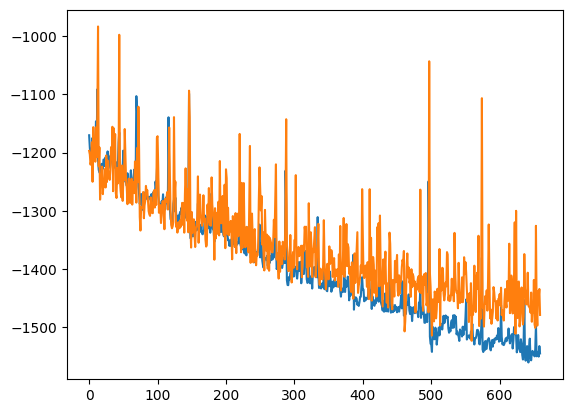

alpha 0.2 default_lr 0.0005


In [40]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    plt.plot(train_curve1)
    plt.plot(valid_curve1)
    plt.show()

print("alpha",alpha, "default_lr", default_lr)

In [41]:
print(datetime.datetime.now())

2023-07-24 08:16:15.807198


# Iter 5

In [42]:
policy_evaluation_iter=4

In [43]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    iwvi.get_sim_rollout_bamdppolicy_data_randomstop()


 0

 1

 2

 3

 4

 5
predict diverge [-0.39887277  8.85268751 -6.81375758  7.75265219] [0.07534074 0.7541718  0.11244958 0.35415526] [22.259691  8.68547  55.24954  21.237312] [11.129846  4.342735 27.62477  10.618656] sim_timestep 75

 6

 7

 8

 9

 10

 11

 12
predict diverge [ 0.28758876  9.23787107 -6.54179211 10.43447444] [0.0510873  0.64292644 0.10450172 1.38105202] [22.259691  8.68547  55.24954  21.237312] [11.129846  4.342735 27.62477  10.618656] sim_timestep 76

 13

 14

 15

 16

 17
predict diverge [ -2.43619156  -2.15470142  10.11294849 -23.20449495] [-0.13954967  5.44475856 -0.34952524 -5.72271729] [22.259691  8.68547  55.24954  21.237312] [11.129846  4.342735 27.62477  10.618656] sim_timestep 188

 18

 19

 20

 21

 22

 23

 24

 25

 26

 27

 28

 29

 30

 31

 32

 33

 34

 35

 36

 37

 38

 39

 40

 41

 42

 43

 44

 45

 46

 47

 48
predict diverge [ 1.30022126  9.42775591 -7.31430814  7.88722423] [0.03183904 0.86535928 0.10051295 0.48804402] [22.2596

In [44]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    iwvi.train_ratio(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, policy=agent.select_action)


train: iter 0  trainloss 0.73211  validloss 1.05686±0.00000  bestvalidloss 1.05686  last_update 0
train: iter 1  trainloss 0.68398  validloss 0.88932±0.00000  bestvalidloss 0.88932  last_update 0
train: iter 2  trainloss 0.68049  validloss 0.91829±0.00000  bestvalidloss 0.88932  last_update 1
train: iter 3  trainloss 0.67011  validloss 0.90691±0.00000  bestvalidloss 0.88932  last_update 2
train: iter 4  trainloss 0.65515  validloss 0.85804±0.00000  bestvalidloss 0.85804  last_update 0
train: iter 5  trainloss 0.65780  validloss 0.85498±0.00000  bestvalidloss 0.85498  last_update 0
train: iter 6  trainloss 0.65658  validloss 0.86242±0.00000  bestvalidloss 0.85498  last_update 1
train: iter 7  trainloss 0.64954  validloss 0.93975±0.00000  bestvalidloss 0.85498  last_update 2
train: iter 8  trainloss 0.65124  validloss 0.84153±0.00000  bestvalidloss 0.84153  last_update 0
train: iter 9  trainloss 0.64331  validloss 0.84656±0.00000  bestvalidloss 0.84153  last_update 1
train: iter 10  trai

train: iter 83  trainloss 0.60485  validloss 0.90894±0.00000  bestvalidloss 0.82487  last_update 8
train: iter 84  trainloss 0.61313  validloss 0.85037±0.00000  bestvalidloss 0.82487  last_update 9
train: iter 85  trainloss 0.60762  validloss 0.84254±0.00000  bestvalidloss 0.82487  last_update 10
train: iter 86  trainloss 0.60450  validloss 0.87316±0.00000  bestvalidloss 0.82487  last_update 11
train: iter 87  trainloss 0.60420  validloss 0.86054±0.00000  bestvalidloss 0.82487  last_update 12
train: iter 88  trainloss 0.60617  validloss 0.89566±0.00000  bestvalidloss 0.82487  last_update 13
train: iter 89  trainloss 0.60646  validloss 0.84962±0.00000  bestvalidloss 0.82487  last_update 14
train: iter 90  trainloss 0.59970  validloss 0.84679±0.00000  bestvalidloss 0.82487  last_update 15
train: iter 91  trainloss 0.59903  validloss 0.87681±0.00000  bestvalidloss 0.82487  last_update 16
train: iter 92  trainloss 0.60135  validloss 0.85862±0.00000  bestvalidloss 0.82487  last_update 17
tr

train: iter 165  trainloss 0.58867  validloss 0.91668±0.00000  bestvalidloss 0.82487  last_update 90
train: iter 166  trainloss 0.58673  validloss 0.84863±0.00000  bestvalidloss 0.82487  last_update 91
train: iter 167  trainloss 0.58699  validloss 0.86204±0.00000  bestvalidloss 0.82487  last_update 92
train: iter 168  trainloss 0.59006  validloss 0.92502±0.00000  bestvalidloss 0.82487  last_update 93
train: iter 169  trainloss 0.59505  validloss 0.86273±0.00000  bestvalidloss 0.82487  last_update 94
train: iter 170  trainloss 0.58923  validloss 0.87637±0.00000  bestvalidloss 0.82487  last_update 95
train: iter 171  trainloss 0.58112  validloss 0.86234±0.00000  bestvalidloss 0.82487  last_update 96
train: iter 172  trainloss 0.58704  validloss 0.86129±0.00000  bestvalidloss 0.82487  last_update 97
train: iter 173  trainloss 0.58353  validloss 0.88328±0.00000  bestvalidloss 0.82487  last_update 98
train: iter 174  trainloss 0.58832  validloss 0.85363±0.00000  bestvalidloss 0.82487  last_

In [45]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    loss_list.append(iwvi.eval_loss(weight_alpha=1.))
    normalized_loss_list.append(iwvi.eval_loss(weight_alpha=alpha))


train_loss:  -7.188216091015936
valid_loss:  -15.465690642547608
weight_alpha 1.0 h_min_tilde -12.324026 ell_tilde -8.84371100132227 kappa_tilde 0.0005360319996996997
train_loss:  -6.137018287754059
valid_loss:  -6.2197162078857415
weight_alpha 0.2 h_min_tilde -12.324026 ell_tilde -6.153557871780396 kappa_tilde 0.0004025695660745016


In [46]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    train_curve1, valid_curve1 = iwvi.train_weighted_vae(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, weight_alpha=alpha, flag=1)
    iwvi.update_mulogvar_offlinedata()


weight_alpha 0.2
train_weighted_vae: enc_dec
train: iter 0  trainloss -1223.03725  validloss -1252.74780±0.00000  bestvalidloss -1252.74780  last_update 0
train: iter 1  trainloss -1225.91839  validloss -1275.91531±0.00000  bestvalidloss -1275.91531  last_update 0
train: iter 2  trainloss -1236.05349  validloss -1281.07539±0.00000  bestvalidloss -1281.07539  last_update 0
train: iter 3  trainloss -1228.11357  validloss -1278.72669±0.00000  bestvalidloss -1281.07539  last_update 1
train: iter 4  trainloss -1205.84938  validloss -1266.68349±0.00000  bestvalidloss -1281.07539  last_update 2
train: iter 5  trainloss -1215.63974  validloss -1124.01012±0.00000  bestvalidloss -1281.07539  last_update 3
train: iter 6  trainloss -1234.54793  validloss -1265.17290±0.00000  bestvalidloss -1281.07539  last_update 4
train: iter 7  trainloss -1247.19437  validloss -1286.77396±0.00000  bestvalidloss -1286.77396  last_update 0
train: iter 8  trainloss -1253.25341  validloss -1316.03184±0.00000  bestva

train: iter 74  trainloss -1244.50966  validloss -1279.88704±0.00000  bestvalidloss -1348.95605  last_update 21
train: iter 75  trainloss -1252.36992  validloss -1272.99625±0.00000  bestvalidloss -1348.95605  last_update 22
train: iter 76  trainloss -1252.32952  validloss -1292.31774±0.00000  bestvalidloss -1348.95605  last_update 23
train: iter 77  trainloss -1242.55972  validloss -1293.49153±0.00000  bestvalidloss -1348.95605  last_update 24
train: iter 78  trainloss -1239.98762  validloss -1289.54767±0.00000  bestvalidloss -1348.95605  last_update 25
train: iter 79  trainloss -1250.74096  validloss -1273.36432±0.00000  bestvalidloss -1348.95605  last_update 26
train: iter 80  trainloss -1260.80711  validloss -1278.70034±0.00000  bestvalidloss -1348.95605  last_update 27
train: iter 81  trainloss -1245.71735  validloss -1319.71359±0.00000  bestvalidloss -1348.95605  last_update 28
train: iter 82  trainloss -1208.93581  validloss -1276.63701±0.00000  bestvalidloss -1348.95605  last_up

train: iter 147  trainloss -1236.94823  validloss -1237.17289±0.00000  bestvalidloss -1360.20714  last_update 17
train: iter 148  trainloss -1262.90519  validloss -1253.50428±0.00000  bestvalidloss -1360.20714  last_update 18
train: iter 149  trainloss -1276.27945  validloss -1266.96662±0.00000  bestvalidloss -1360.20714  last_update 19
train: iter 150  trainloss -1276.21290  validloss -1307.80582±0.00000  bestvalidloss -1360.20714  last_update 20
train: iter 151  trainloss -1287.53921  validloss -1325.78022±0.00000  bestvalidloss -1360.20714  last_update 21
train: iter 152  trainloss -1278.00468  validloss -1324.95666±0.00000  bestvalidloss -1360.20714  last_update 22
train: iter 153  trainloss -1267.88636  validloss -1310.21814±0.00000  bestvalidloss -1360.20714  last_update 23
train: iter 154  trainloss -1274.00224  validloss -1304.83042±0.00000  bestvalidloss -1360.20714  last_update 24
train: iter 155  trainloss -1270.68466  validloss -1306.22374±0.00000  bestvalidloss -1360.20714

train: iter 220  trainloss -1275.84437  validloss -1235.78482±0.00000  bestvalidloss -1382.66215  last_update 29
train: iter 221  trainloss -1277.39479  validloss -1321.52304±0.00000  bestvalidloss -1382.66215  last_update 30
train: iter 222  trainloss -1282.44801  validloss -1352.62307±0.00000  bestvalidloss -1382.66215  last_update 31
train: iter 223  trainloss -1284.63223  validloss -1281.43686±0.00000  bestvalidloss -1382.66215  last_update 32
train: iter 224  trainloss -1261.99307  validloss -1313.88442±0.00000  bestvalidloss -1382.66215  last_update 33
train: iter 225  trainloss -1251.94299  validloss -1274.67598±0.00000  bestvalidloss -1382.66215  last_update 34
train: iter 226  trainloss -1239.96175  validloss -1288.86995±0.00000  bestvalidloss -1382.66215  last_update 35
train: iter 227  trainloss -1288.54673  validloss -1326.08551±0.00000  bestvalidloss -1382.66215  last_update 36
train: iter 228  trainloss -1293.45633  validloss -1318.28226±0.00000  bestvalidloss -1382.66215

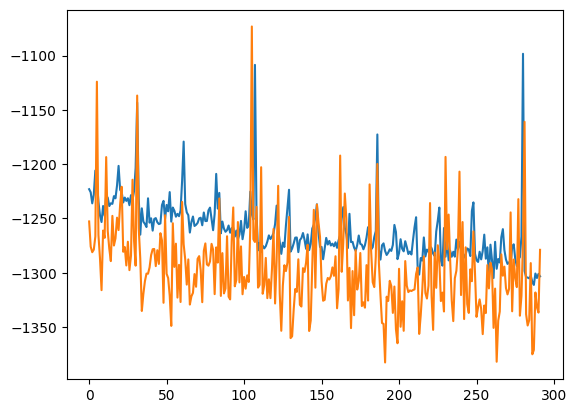

alpha 0.2 default_lr 0.0005


In [47]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    plt.plot(train_curve1)
    plt.plot(valid_curve1)
    plt.show()

print("alpha",alpha, "default_lr", default_lr)

In [48]:
print(datetime.datetime.now())

2023-07-24 08:40:36.944153


# 評価関数計算

In [49]:
iwvi.get_sim_rollout_bamdppolicy_data_randomstop()


 0

 1

 2

 3

 4

 5

 6

 7

 8

 9

 10

 11

 12

 13

 14

 15

 16

 17

 18

 19

 20

 21

 22

 23

 24

 25

 26

 27

 28

 29

 30

 31

 32

 33

 34

 35

 36

 37

 38

 39

 40

 41

 42

 43

 44

 45

 46

 47

 48

 49

 50

 51

 52

 53

 54

 55

 56

 57

 58

 59

 60

 61

 62

 63

 64

 65

 66

 67

 68

 69

 70

 71

 72

 73

 74

 75

 76

 77

 78
predict diverge [-0.40569081  9.12997416 -5.30540397  7.87716866] [0.08355464 0.66639788 0.09115765 0.07227297] [22.259691  8.68547  55.24954  21.237312] [11.129846  4.342735 27.62477  10.618656] sim_timestep 88

 79

 80

 81

 82

 83

 84

 85

 86

 87

 88

 89

 90

 91

 92

 93

 94

 95

 96

 97

 98

 99
 


In [50]:
iwvi.train_ratio(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, policy=agent.select_action)


train: iter 0  trainloss 0.69340  validloss 0.90771±0.00000  bestvalidloss 0.90771  last_update 0
train: iter 1  trainloss 0.67239  validloss 0.89350±0.00000  bestvalidloss 0.89350  last_update 0
train: iter 2  trainloss 0.66888  validloss 0.85188±0.00000  bestvalidloss 0.85188  last_update 0
train: iter 3  trainloss 0.66536  validloss 0.82547±0.00000  bestvalidloss 0.82547  last_update 0
train: iter 4  trainloss 0.66153  validloss 0.85370±0.00000  bestvalidloss 0.82547  last_update 1
train: iter 5  trainloss 0.65981  validloss 0.83942±0.00000  bestvalidloss 0.82547  last_update 2
train: iter 6  trainloss 0.66182  validloss 0.85271±0.00000  bestvalidloss 0.82547  last_update 3
train: iter 7  trainloss 0.65278  validloss 0.85144±0.00000  bestvalidloss 0.82547  last_update 4
train: iter 8  trainloss 0.65382  validloss 0.83575±0.00000  bestvalidloss 0.82547  last_update 5
train: iter 9  trainloss 0.65085  validloss 0.83685±0.00000  bestvalidloss 0.82547  last_update 6
train: iter 10  trai

train: iter 83  trainloss 0.61042  validloss 0.80277±0.00000  bestvalidloss 0.79666  last_update 7
train: iter 84  trainloss 0.61944  validloss 0.86011±0.00000  bestvalidloss 0.79666  last_update 8
train: iter 85  trainloss 0.62100  validloss 0.83552±0.00000  bestvalidloss 0.79666  last_update 9
train: iter 86  trainloss 0.61472  validloss 0.80434±0.00000  bestvalidloss 0.79666  last_update 10
train: iter 87  trainloss 0.61362  validloss 0.79876±0.00000  bestvalidloss 0.79666  last_update 11
train: iter 88  trainloss 0.61047  validloss 0.82306±0.00000  bestvalidloss 0.79666  last_update 12
train: iter 89  trainloss 0.62160  validloss 0.80927±0.00000  bestvalidloss 0.79666  last_update 13
train: iter 90  trainloss 0.62586  validloss 0.78924±0.00000  bestvalidloss 0.78924  last_update 0
train: iter 91  trainloss 0.61069  validloss 0.79305±0.00000  bestvalidloss 0.78924  last_update 1
train: iter 92  trainloss 0.61569  validloss 0.79292±0.00000  bestvalidloss 0.78924  last_update 2
train:

train: iter 165  trainloss 0.59780  validloss 0.81392±0.00000  bestvalidloss 0.78924  last_update 75
train: iter 166  trainloss 0.59601  validloss 0.84369±0.00000  bestvalidloss 0.78924  last_update 76
train: iter 167  trainloss 0.59933  validloss 0.85268±0.00000  bestvalidloss 0.78924  last_update 77
train: iter 168  trainloss 0.59592  validloss 0.79867±0.00000  bestvalidloss 0.78924  last_update 78
train: iter 169  trainloss 0.59852  validloss 0.83046±0.00000  bestvalidloss 0.78924  last_update 79
train: iter 170  trainloss 0.59225  validloss 0.82327±0.00000  bestvalidloss 0.78924  last_update 80
train: iter 171  trainloss 0.59897  validloss 0.81079±0.00000  bestvalidloss 0.78924  last_update 81
train: iter 172  trainloss 0.60141  validloss 0.86888±0.00000  bestvalidloss 0.78924  last_update 82
train: iter 173  trainloss 0.59966  validloss 0.80854±0.00000  bestvalidloss 0.78924  last_update 83
train: iter 174  trainloss 0.59709  validloss 0.84821±0.00000  bestvalidloss 0.78924  last_

([0.6934030566364526,
  0.6723930349573493,
  0.6688801160082221,
  0.6653573652729392,
  0.6615299871191382,
  0.6598055271431804,
  0.6618187498301268,
  0.6527821289375424,
  0.6538188708946109,
  0.6508491989225149,
  0.6655451338738203,
  0.648937132768333,
  0.6544436451047659,
  0.6452023424208164,
  0.6418526530265808,
  0.6487970978021622,
  0.6472167069092393,
  0.6444225726649165,
  0.642168048582971,
  0.6445699134841562,
  0.6403716295957566,
  0.6407617323100567,
  0.6402068911120296,
  0.643423929437995,
  0.6380072237923742,
  0.6374281076714396,
  0.638367784768343,
  0.6375148432329297,
  0.6417564503848553,
  0.63504543248564,
  0.6350089550018311,
  0.6286431381478905,
  0.6412114817649126,
  0.6364840283058584,
  0.6306256780400872,
  0.6296642241999507,
  0.6348134554922581,
  0.631567905843258,
  0.6303753469139337,
  0.6305219335481524,
  0.6320167366415262,
  0.6315873200073838,
  0.631454860419035,
  0.626250502280891,
  0.6293377263471485,
  0.630105531401932

In [51]:
loss_list.append(iwvi.eval_loss(weight_alpha=1.))
normalized_loss_list.append(iwvi.eval_loss(weight_alpha=alpha))


train_loss:  -9.90023648273796
valid_loss:  -17.865919551086428
weight_alpha 1.0 h_min_tilde -12.32414 ell_tilde -11.493373096407653 kappa_tilde 0.0010971361184141863
train_loss:  -6.777367414855957
valid_loss:  -6.860354795837402
weight_alpha 0.2 h_min_tilde -12.32414 ell_tilde -6.793964891052245 kappa_tilde 0.00042523653857081073


In [52]:
train_curve, valid_curve = iwvi.train_initial_belief(num_iter=100000, lr=1e-3, early_stop_step=default_early)


train: iter 0  trainloss 121.00027  validloss 134.36364±0.00000  bestvalidloss 134.36364  last_update 0
train: iter 1  trainloss 97.37744  validloss 106.92932±0.00000  bestvalidloss 106.92932  last_update 0
train: iter 2  trainloss 77.58843  validloss 84.10194±0.00000  bestvalidloss 84.10194  last_update 0
train: iter 3  trainloss 62.96601  validloss 67.80059±0.00000  bestvalidloss 67.80059  last_update 0
train: iter 4  trainloss 51.18584  validloss 53.31254±0.00000  bestvalidloss 53.31254  last_update 0
train: iter 5  trainloss 41.75168  validloss 43.86283±0.00000  bestvalidloss 43.86283  last_update 0
train: iter 6  trainloss 34.60860  validloss 35.45788±0.00000  bestvalidloss 35.45788  last_update 0
train: iter 7  trainloss 28.90219  validloss 29.32265±0.00000  bestvalidloss 29.32265  last_update 0
train: iter 8  trainloss 23.46792  validloss 24.37858±0.00000  bestvalidloss 24.37858  last_update 0
train: iter 9  trainloss 19.53656  validloss 19.48455±0.00000  bestvalidloss 19.48455 

train: iter 88  trainloss -0.62414  validloss -1.15422±0.00000  bestvalidloss -1.26414  last_update 16
train: iter 89  trainloss -0.59825  validloss -1.18846±0.00000  bestvalidloss -1.26414  last_update 17
train: iter 90  trainloss -0.60311  validloss -1.20114±0.00000  bestvalidloss -1.26414  last_update 18
train: iter 91  trainloss -0.61324  validloss -1.18176±0.00000  bestvalidloss -1.26414  last_update 19
train: iter 92  trainloss -0.62527  validloss -1.19422±0.00000  bestvalidloss -1.26414  last_update 20
train: iter 93  trainloss -0.62480  validloss -1.13036±0.00000  bestvalidloss -1.26414  last_update 21
train: iter 94  trainloss -0.67306  validloss -1.18123±0.00000  bestvalidloss -1.26414  last_update 22
train: iter 95  trainloss -0.64420  validloss -1.08772±0.00000  bestvalidloss -1.26414  last_update 23
train: iter 96  trainloss -0.61424  validloss -1.19518±0.00000  bestvalidloss -1.26414  last_update 24
train: iter 97  trainloss -0.64703  validloss -1.16311±0.00000  bestvalid

In [53]:
print(iwvi.initial_belief)


Parameter containing:
tensor([ 0.4932,  1.3606, -2.9159, -4.5676], requires_grad=True)


In [54]:
train_curve, valid_curve = iwvi.train_penalty(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early)

train: iter 0  trainloss 1.58125  validloss 7.19173±0.00000  bestvalidloss 7.19173  last_update 0
train: iter 1  trainloss 1.46481  validloss 8.36956±0.00000  bestvalidloss 7.19173  last_update 1
train: iter 2  trainloss 1.49742  validloss 7.20241±0.00000  bestvalidloss 7.19173  last_update 2
train: iter 3  trainloss 1.47206  validloss 6.75077±0.00000  bestvalidloss 6.75077  last_update 0
train: iter 4  trainloss 1.45165  validloss 7.34763±0.00000  bestvalidloss 6.75077  last_update 1
train: iter 5  trainloss 1.49508  validloss 8.71278±0.00000  bestvalidloss 6.75077  last_update 2
train: iter 6  trainloss 1.44508  validloss 7.59645±0.00000  bestvalidloss 6.75077  last_update 3
train: iter 7  trainloss 1.45078  validloss 7.23501±0.00000  bestvalidloss 6.75077  last_update 4
train: iter 8  trainloss 1.46777  validloss 7.61296±0.00000  bestvalidloss 6.75077  last_update 5
train: iter 9  trainloss 1.42020  validloss 8.44395±0.00000  bestvalidloss 6.75077  last_update 6
train: iter 10  trai

train: iter 84  trainloss 1.34655  validloss 8.01667±0.00000  bestvalidloss 6.70891  last_update 67
train: iter 85  trainloss 1.34580  validloss 9.07147±0.00000  bestvalidloss 6.70891  last_update 68
train: iter 86  trainloss 1.32989  validloss 7.02673±0.00000  bestvalidloss 6.70891  last_update 69
train: iter 87  trainloss 1.33061  validloss 9.04574±0.00000  bestvalidloss 6.70891  last_update 70
train: iter 88  trainloss 1.37362  validloss 7.33930±0.00000  bestvalidloss 6.70891  last_update 71
train: iter 89  trainloss 1.36967  validloss 7.83742±0.00000  bestvalidloss 6.70891  last_update 72
train: iter 90  trainloss 1.35066  validloss 8.46834±0.00000  bestvalidloss 6.70891  last_update 73
train: iter 91  trainloss 1.34576  validloss 7.55326±0.00000  bestvalidloss 6.70891  last_update 74
train: iter 92  trainloss 1.34291  validloss 7.80122±0.00000  bestvalidloss 6.70891  last_update 75
train: iter 93  trainloss 1.36396  validloss 8.47698±0.00000  bestvalidloss 6.70891  last_update 76


In [55]:
iwvi.save(ckpt_key="policy_optimization_iter1")

iwvi save ckpt1, ckpt2 ckpt_iwvi_basepartcartpole_policy_optimization_iter1 ckpt_iwvi_cartpole_policy_optimization_iter1
base save ckpt ckpt_basevi_cartpole_policy_optimization_iter1
base load self.initial_belief.data.sum() tensor(-5.6296)
base load dec.state_dict()['net_phat.0.weight'].sum() tensor(-19.8965)


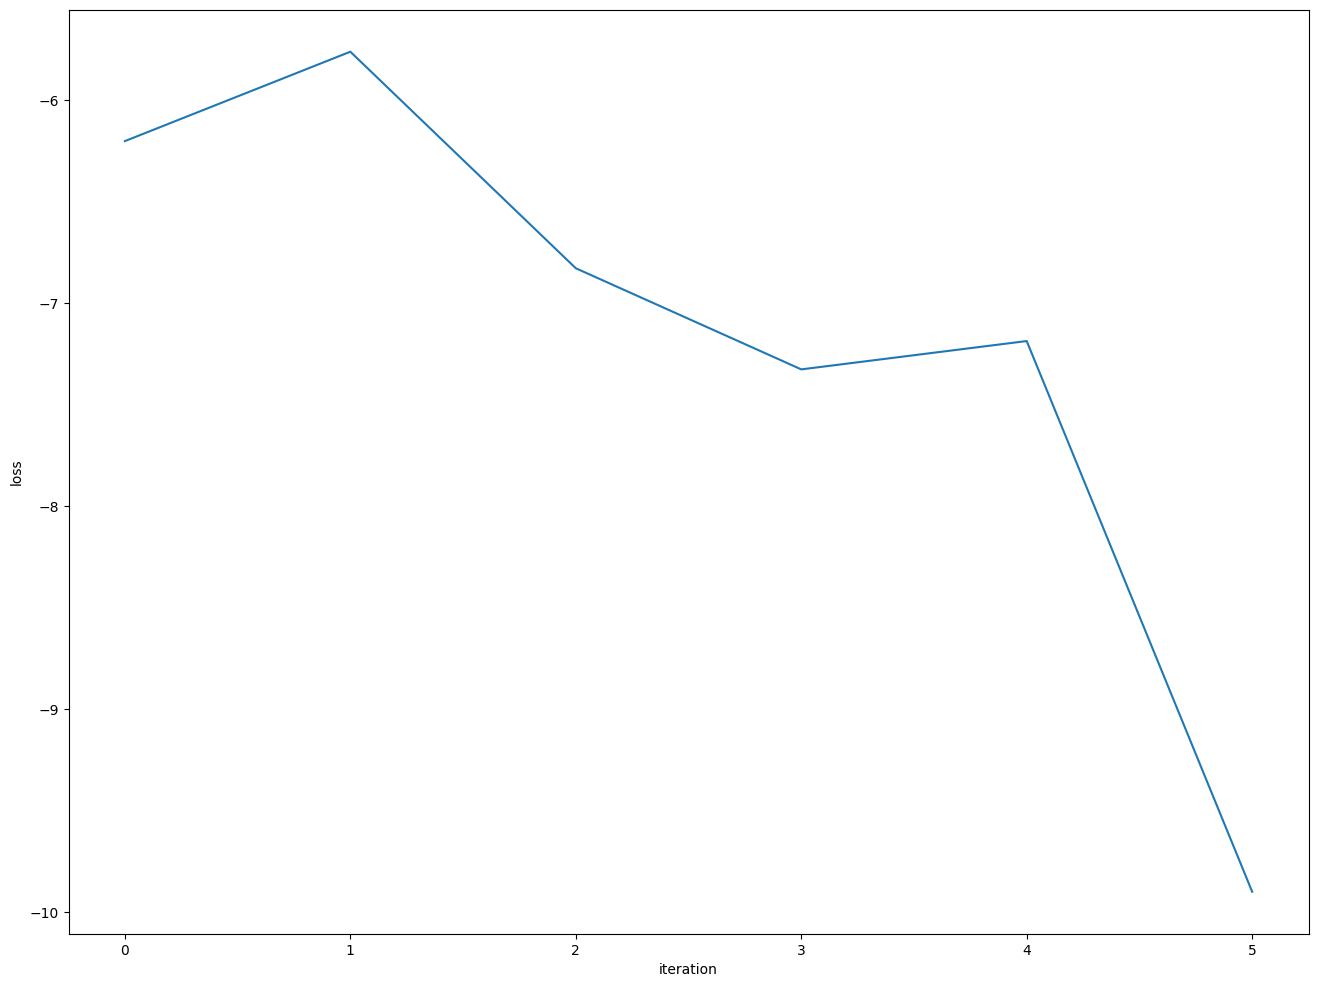

In [56]:
loss_array = np.array(loss_list)
plt.figure(figsize=(16,12))
plt.plot(loss_array[:,0])
plt.xlabel("iteration")
plt.ylabel("loss")
plt.savefig(figfilenamehead+"learning_curve.png")
plt.savefig(figfilenamehead+"learning_curve.eps")
# plt.savefig(figfilenamehead+"policy_evaluartion_learning_curve.pdf")

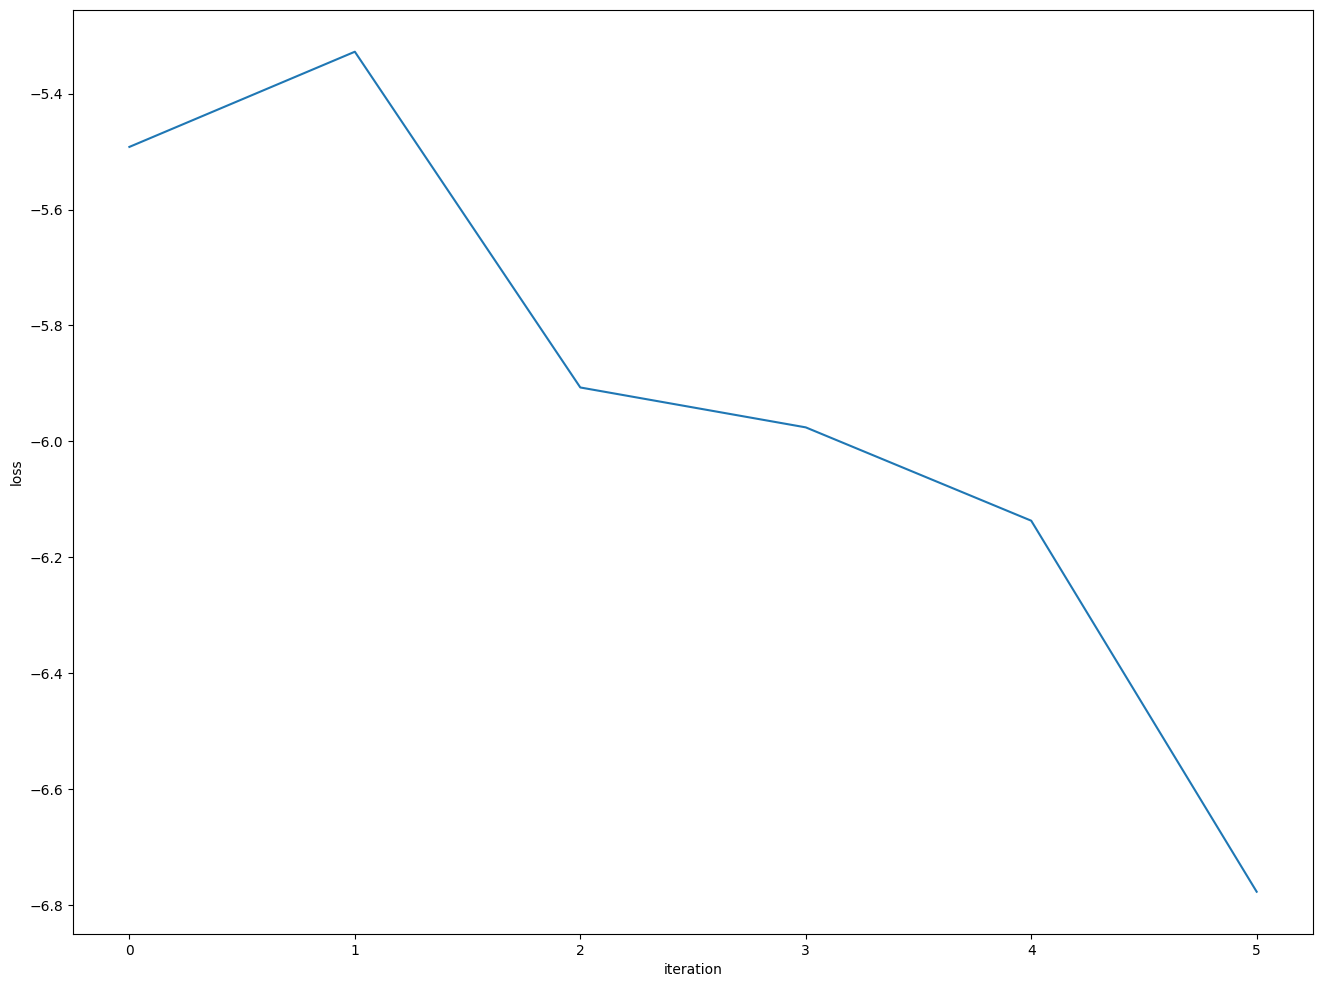

In [57]:
normalized_loss_array = np.array(normalized_loss_list)
plt.figure(figsize=(16,12))
plt.plot(normalized_loss_array[:,0])
plt.xlabel("iteration")
plt.ylabel("loss")
plt.savefig(figfilenamehead+"learning_curve_normalized_"+env_str+".png")
plt.savefig(figfilenamehead+"learning_curve_normalized_"+env_str+".eps")